# **Chapter 13 (TensorFlow Recipes)**
## *Deep Learning for Time Series Forecasting*, 

This chapter covers more advanced deep learning architectures using TensorFlow/Keras and PyTorch. The chapter starts with a high-level API (Keras) and then dives into more complex implementations, using a lower-level API (PyTorch).


In this chapter, you will see the following recipes:
* Forecasting with an RNN using Keras
* Forecasting with LSTM using Keras
* Forecasting with a GRU using Keras

# Technical Requirements

It is recommended that you create two separate virtual Python environments – one for TensorFlow/Keras and one for PyTorch. You can install all the required dependencies and their specific versions without causing conflicts in other environments. If you prefer, you can still try and install them together in a new virtual environment. If you need a quick refresher on creating a virtual Python environment, check out the *Development environment setup* recipe from **Chapter 1**, *Getting Started with Time Series Analysis*. The chapter covers two methods – using `conda` and `venv`.

The following instructions will create two virtual environments using `conda`. You can call the environments any name you like.

### Installing TensorFlow

The following example will name the environment TensorFlow:
```
conda create -n tensorflow python=3.9 -y
conda activate tensorflow
pip install tensorflow
```

For the latest instructions or troubleshooting, please visit the main page here: https://www.tensorflow.org/install.

To make the new tensorflow environment visible within Jupyter, you can run the following code:
```
python -m ipykernel install --user --name tensorflow --displayname "tensorflow"
```

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path

import warnings
warnings.filterwarnings('ignore')
# plt.rc("figure", figsize=(16, 4))

In [6]:
import matplotlib 
import tensorflow as tf

print(f'''
Matplotlib -> {matplotlib.__version__}
pandas -> {pd.__version__}   
numpy -> {np.__version__}
tensorflow -> {tf.__version__}
''')


Matplotlib -> 3.10.1
pandas -> 2.2.3   
numpy -> 2.1.3
tensorflow -> 2.19.0



In [8]:
###### configurations for image quality#######
plt.rcParams["figure.figsize"] = [14, 7]   ##
# plt.rcParams['figure.dpi'] = 300           ## 300 for printing
plt.rc('font', size=8)                     ## 
plt.rc('axes', titlesize=16)               ## 
plt.rc('axes', labelsize=14)               ##
plt.rc('xtick', labelsize=10)              ##
plt.rc('ytick', labelsize=10)              ##
plt.rc('legend', fontsize=10)              ##
plt.rc('figure', titlesize=12)             ## 
#############################################

# Preparing Time Series Data for Deep Learning

In [10]:
path = Path('../../datasets/Ch13/')

In [12]:
daily_temp = pd.read_csv(path.joinpath('daily_weather.csv'), 
                      index_col='DateTime', 
                      parse_dates=True)
daily_temp.columns = ['y']
energy = pd.read_csv(path.joinpath('energy_consumption.csv'), 
                     index_col='Month', 
                     parse_dates=True)
energy.columns = ['y']

air = pd.read_csv(path.joinpath('air_passenger.csv'), 
                  index_col='date', 
                  parse_dates=True)
air.columns = ['y']

In [14]:
daily_temp.index.freq = 'D'
energy.index.freq = 'MS'
air.index.freq = 'M'

In [16]:
print(daily_temp.index.freq)
print(energy.index.freq)
print(air.index.freq)

<Day>
<MonthBegin>
<MonthEnd>


### Visualize the time series data

<Axes: title={'center': 'Monthly Passengers'}, xlabel='date'>

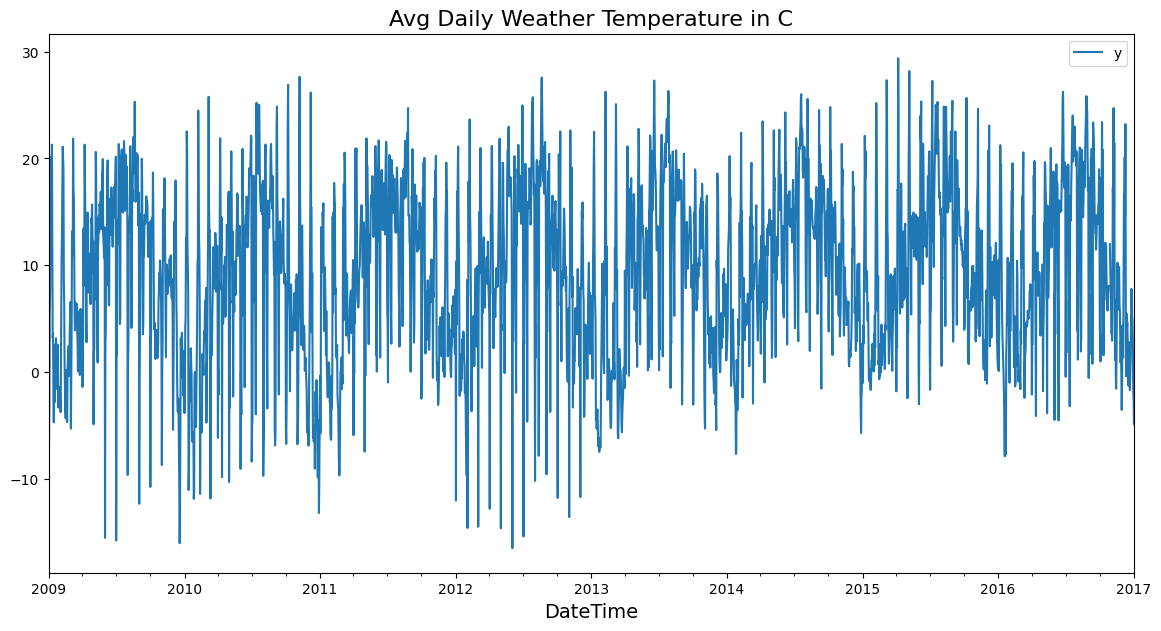

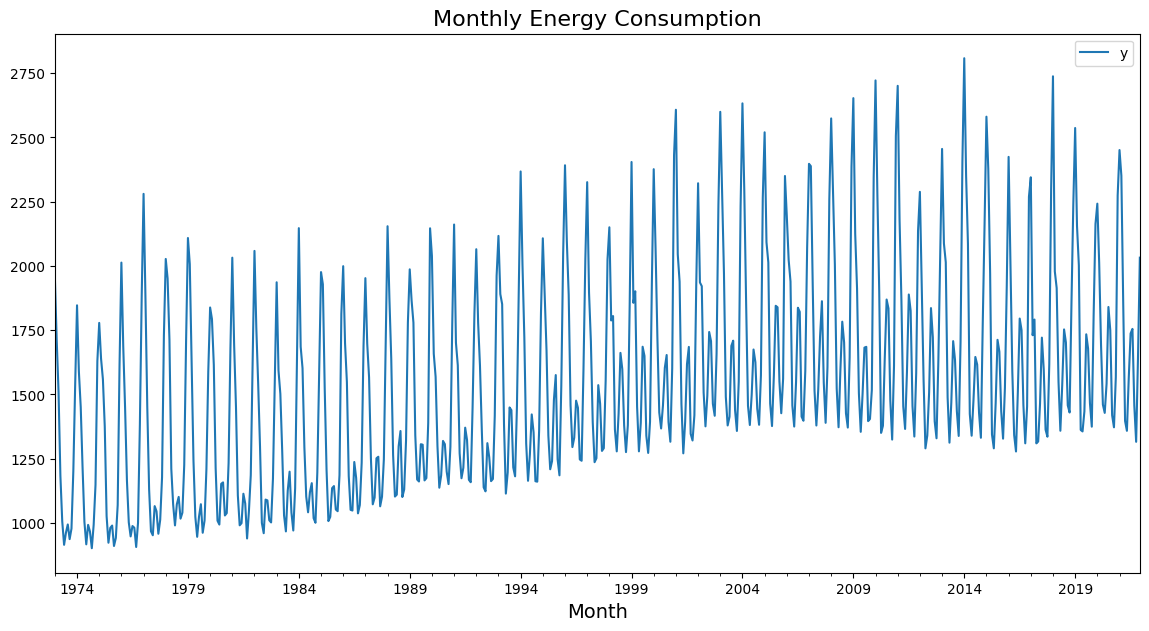

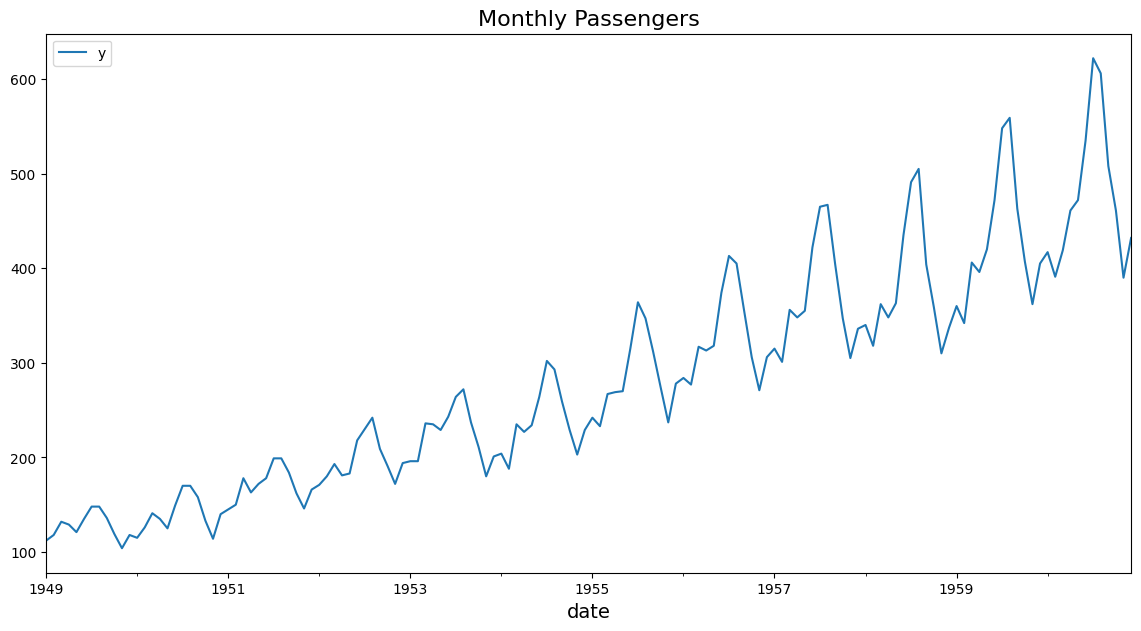

In [19]:
daily_temp.plot(title='Avg Daily Weather Temperature in C')
energy.plot(title='Monthly Energy Consumption')
air.plot(title='Monthly Passengers')

## Tranform the data sets
### Windowing

In [22]:
air_cp = air.copy()
en_cp = energy.copy()
dw_cp = daily_temp.copy()

In [24]:
def handle_missing_data(df):
    n = int(df.isna().sum())
    if n > 0:
        print(f'found {n} missing observations...')
        df.ffill(inplace=True)
        
        
def one_step_forecast(df, window):
    d = df.values
    x = []
    n = len(df)
    idx = df.index[:-window]
    for start in range(n-window):
        end = start + window
        x.append(d[start:end])
    cols = [f'x_{i}' for i in range(1, window+1)]
    x = np.array(x).reshape(n-window, -1)
    y = df.iloc[window:].values
    df_xs = pd.DataFrame(x, columns=cols, index=idx)
    df_y = pd.DataFrame(y.reshape(-1), columns=['y'], index=idx)
    return pd.concat([df_xs, df_y], axis=1).dropna()
    

def split_data(df, test_split=0.15):
    n = int(len(df) * test_split)
    train, test = df[:-n], df[-n:]
    return train, test

In [26]:
for df in [air_cp, en_cp, dw_cp]:
    handle_missing_data(df)

found 2 missing observations...


In [28]:
air_df = one_step_forecast(air_cp, 10)
en_df = one_step_forecast(en_cp, 10)
dw_df = one_step_forecast(dw_cp, 10)
print(air_df.shape)
print(en_df.shape)
print(dw_df.shape)

(134, 11)
(578, 11)
(2913, 11)


### Scale and split data

In [30]:
class Standardize:
    def __init__(self, df, split=0.10):
        self.data = df
        self.split = split
    
    def split_data(self):
        n = int(len(self.data) * self.split)
        train, test = self.data.iloc[:-n], self.data.iloc[-n:]
        n = int(len(train) * self.split)
        train, val = train.iloc[:-n], train.iloc[-n:]
        assert len(test) + len(train) + len(val) == len(self.data)
        return train, test, val
    
    def _transform(self, data):
        data_s = (data - self.mu)/self.sigma
        return data_s
    
    def fit_transform(self):
        train, test, val = self.split_data()
        self.mu, self.sigma = train.mean(), train.std()
        train_s = self._transform(train)
        test_s = self._transform(test)
        val_s = self._transform(val)
        return train_s, test_s, val_s
    
    def inverse(self, data):
        return (data * self.sigma)+self.mu
        
    def inverse_y(self, data):
        return (data * self.sigma[-1])+self.mu[-1]

In [32]:
scale_air = Standardize(air_df)
scale_dw = Standardize(dw_df)
scale_en = Standardize(en_df)

train_air, test_air, val_air = scale_air.fit_transform()
train_dw, test_dw, val_dw = scale_dw.fit_transform()
train_en, test_en, val_en = scale_en.fit_transform()

In [34]:
print(f'''
air: train: {len(train_air)} , test: {len(test_air)}, val:{len(val_air)}
weather: train: {len(train_dw)} , test: {len(test_dw)}, val:{len(val_dw)}
energy: train: {len(train_en)} , test: {len(test_en)}, val: {len(val_en)}
''')


air: train: 109 , test: 13, val:12
weather: train: 2360 , test: 291, val:262
energy: train: 469 , test: 57, val: 52



In [36]:
train_air.head()

,x_1,x_2,x_3,x_4,x_5,x_6,x_7,x_8,x_9,x_10,y
date,,,,,,,,,,,
1949-01-31,-1.397191,-1.355576,-1.215965,-1.273158,-1.388829,-1.241504,-1.097475,-1.099026,-1.245575,-1.452102,-1.645982
1949-02-28,-1.327272,-1.191673,-1.251032,-1.366593,-1.225652,-1.092114,-1.097475,-1.228860,-1.428232,-1.613479,-1.494104
1949-03-31,-1.164130,-1.226795,-1.344543,-1.203082,-1.074129,-1.092114,-1.231445,-1.412792,-1.589400,-1.462860,-1.526649
1949-04-30,-1.199089,-1.320454,-1.180898,-1.051250,-1.074129,-1.230012,-1.421237,-1.575085,-1.438977,-1.495136,-1.407316
1949-05-31,-1.292313,-1.156552,-1.028943,-1.051250,-1.213996,-1.425368,-1.588701,-1.423612,-1.471210,-1.376792,-1.244589


In [38]:
scale_air.inverse(train_air).head()

,x_1,x_2,x_3,x_4,x_5,x_6,x_7,x_8,x_9,x_10,y
date,,,,,,,,,,,
1949-01-31,112.0,118.0,132.0,129.0,121.0,135.0,148.0,148.0,136.0,119.0,104.0
1949-02-28,118.0,132.0,129.0,121.0,135.0,148.0,148.0,136.0,119.0,104.0,118.0
1949-03-31,132.0,129.0,121.0,135.0,148.0,148.0,136.0,119.0,104.0,118.0,115.0
1949-04-30,129.0,121.0,135.0,148.0,148.0,136.0,119.0,104.0,118.0,115.0,126.0
1949-05-31,121.0,135.0,148.0,148.0,136.0,119.0,104.0,118.0,115.0,126.0,141.0


In [40]:
scale_air.inverse_y(train_air.iloc[:, -1]).head()

date
1949-01-31    104.0
1949-02-28    118.0
1949-03-31    115.0
1949-04-30    126.0
1949-05-31    141.0
Freq: ME, Name: y, dtype: float64

### Split into X and Y (Features and Target)

In [43]:
def features_target_ts(*args):
    y = [col.pop('y').values.reshape(-1, 1) for col in args]
    x = [col.values.reshape(*col.shape, 1)
                   for col in args]
    return *y, *x

In [45]:
(y_train_air, 
 y_val_air, 
 y_test_air, 
 x_train_air, 
 x_val_air, 
 x_test_air) = features_target_ts(train_air, 
                               val_air, 
                               test_air)

In [47]:
(y_train_dw, 
y_val_dw, 
y_test_dw, 
x_train_dw, 
x_val_dw, 
x_test_dw) = features_target_ts(train_dw, 
                             val_dw, 
                             test_dw)

In [49]:
(y_train_en, 
y_val_en, 
y_test_en, 
x_train_en, 
x_val_en, 
x_test_en) = features_target_ts(train_en, 
                             val_en, 
                             test_en)

In [51]:
scale_air.inverse_y(y_train_air)[0:5]

array([[104.],
       [118.],
       [115.],
       [126.],
       [141.]])

In [53]:
x_train_air.shape

(109, 10, 1)

In [55]:
type(x_train_air)

numpy.ndarray

In [57]:
print(y_train_air.shape,
y_test_air.shape,
y_val_air.shape)

(109, 1) (13, 1) (12, 1)


### Using Scikit-Learn for Scaling and Splitting

In [60]:
# from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import StandardScaler

In [62]:
# train, test = train_test_split(air_d, test_size=0.15, shuffle=False)
# train, val = train_test_split(train, test_size=0.15, shuffle=False)

In [64]:
# scale = StandardScaler()
# scale.fit(train)

In [66]:
# train_scaled = scale.transform(train)
# test_scaled = scale.transform(test)
# val_scaled = scale.transform(val)

In [68]:
# x_train, y_train = train_scaled[:, :-1], train_scaled[:, -1]
# x_test, y_test = test_scaled[:, :-1], test_scaled[:, -1]
# x_val, y_val = val_scaled[:, :-1], val_scaled[:, -1]

----
# Forecasting with Keras

In [71]:
from tensorflow.keras import Sequential
from tensorflow import keras
from tensorflow.keras.metrics import RootMeanSquaredError, MeanAbsoluteError
from keras.layers import (BatchNormalization, Dense,  
                TimeDistributed, Bidirectional, 
                SimpleRNN, GRU, LSTM, Dropout)

## SimpleRNN

In [74]:
def create_model(train, units, dropout=0.2):
    model = keras.Sequential()
    model.add(SimpleRNN(units=units,
                        return_sequences=False,
                        input_shape=(train.shape[1], 
                                     train.shape[2])))
    model.add(Dropout(dropout))
    model.add(Dense(1))
    
    return model

In [76]:
def train_model_ts(model, 
                x_train, y_train, x_val, y_val, 
                epochs=500, 
                patience=12, 
                batch_size=32):
    
    model.compile(optimizer='adam', 
                  loss='mean_squared_error', 
                  metrics=[RootMeanSquaredError(), 
                           MeanAbsoluteError()])
    
    es = keras.callbacks.EarlyStopping(
                    monitor="val_loss", 
                    min_delta=0, 
                    patience=patience)
    
    history = model.fit(x_train,y_train, 
              shuffle=False, epochs=epochs,
              batch_size=batch_size, 
              validation_data=(x_val, y_val),
              callbacks=[es], verbose=1)
    return history

In [78]:
def plot_forecast(model, x_test, y_test, index, history):
    fig, ax = plt.subplots(2, 1)
    (pd.Series(history.history['loss'])
                      .plot(style='k',alpha=0.50, title='Loss by Epoch',
                            ax = ax[0], label='loss'))
    (pd.Series(history.history['val_loss'])
                      .plot(style='k',ax=ax[0],label='val_loss'))
    ax[0].legend()
    predicted = model.predict(x_test)
    pd.Series(y_test.reshape(-1), 
              index=index).plot(style='k--', alpha=0.5, ax=ax[1], 
                                title='Forecast vs Actual',
                                label='actual')
    pd.Series(predicted.reshape(-1), 
              index=index).plot(
            style='k',label='Forecast', ax=ax[1])
    fig.tight_layout()
    ax[1].legend();plt.show()

**Another version to plot three subplots for performance measure in RMSE, MAE, and forecast**

In [81]:
# def plot_forecast(model, x_test, y_test, index, history):
#     plt.figure(figsize=(20, 10))
#     ax1 = plt.subplot2grid((2, 2), (0, 0))
#     pd.Series(history.history['root_mean_squared_error']).plot(style='k',
#                                                                alpha=0.50,
#                                                                ax=ax1, 
#                                                                title='RMSE by EPOCH',
#                                                               label='rmse')
#     pd.Series(history.history['val_root_mean_squared_error']).plot(style='k',
#                                                                    ax=ax1,
#                                                                   label='val_rmse')
#     plt.legend()

#     ax2 = plt.subplot2grid((2, 2), (0, 1))
#     pd.Series(history.history['mean_absolute_error']).plot(style='k',
#                                                            alpha=0.50,
#                                                            ax=ax2,
#                                                           title='MAE by EPOCH',
#                                                           label='mae')
#     pd.Series(history.history['val_mean_absolute_error']).plot(style='k',
#                                                                ax=ax2,
#                                                               label='val_mae')
#     plt.legend()
#     ax3 = plt.subplot2grid((2, 2), (1, 0), colspan=2)
#     predicted = model.predict(x_test)
#     pd.Series(y_test.reshape(-1), 
#               index=index).plot(style='k--', alpha=0.5, ax=ax3, 
#                                 title='Forecast vs Actual',
#                                label='actual')
#     pd.Series(predicted.reshape(-1), 
#               index=index).plot(style='k', label='Forecast', ax=ax3)
#     plt.legend();plt.show()


### Air Passenger

In [84]:
tf.keras.backend.clear_session()

In [86]:
model_a_simpleRNN = create_model(train=x_train_air, units=32)

In [88]:
model_a_simpleRNN

<Sequential name=sequential, built=True>

In [90]:
model_a_simpleRNN.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn (SimpleRNN)          │ (None, 32)             │         1,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,121 (4.38 KB)

 Trainable params: 1,121 (4.38 KB)

 Non-trainable params: 0 (0.00 B)

In [92]:
history_a_simpleRNN = train_model_ts(model_a_simpleRNN, x_train_air, y_train_air, x_val_air, y_val_air)

Epoch 1/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 1.9722 - mean_absolute_error: 1.2163 - root_mean_squared_error: 1.3943 - val_loss: 4.6465 - val_mean_absolute_error: 2.0151 - val_root_mean_squared_error: 2.1556
Epoch 2/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.1860 - mean_absolute_error: 0.9135 - root_mean_squared_error: 1.0833 - val_loss: 3.4944 - val_mean_absolute_error: 1.7104 - val_root_mean_squared_error: 1.8693
Epoch 3/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.6622 - mean_absolute_error: 0.6571 - root_mean_squared_error: 0.8114 - val_loss: 2.6204 - val_mean_absolute_error: 1.4349 - val_root_mean_squared_error: 1.6188
Epoch 4/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.3814 - mean_absolute_error: 0.5033 - root_mean_squared_error: 0.6158 - val_loss: 1.9910 - val_mean_absolute_error: 1.1990 - val_root_mean_squared_error: 1.4110
Epoch 5/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.3586 - mean_absolute_error: 0.4370 - root_mean_squared_error: 0

In [94]:
history_a_simpleRNN.history.keys()

dict_keys(['loss', 'mean_absolute_error', 'root_mean_squared_error', 'val_loss', 'val_mean_absolute_error', 'val_root_mean_squared_error'])

In [96]:
model_a_simpleRNN.evaluate(x=x_test_air, y=y_test_air)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.9203 - mean_absolute_error: 0.8337 - root_mean_squared_error: 0.9593


[0.9203020930290222, 0.9593237638473511, 0.8336542844772339]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


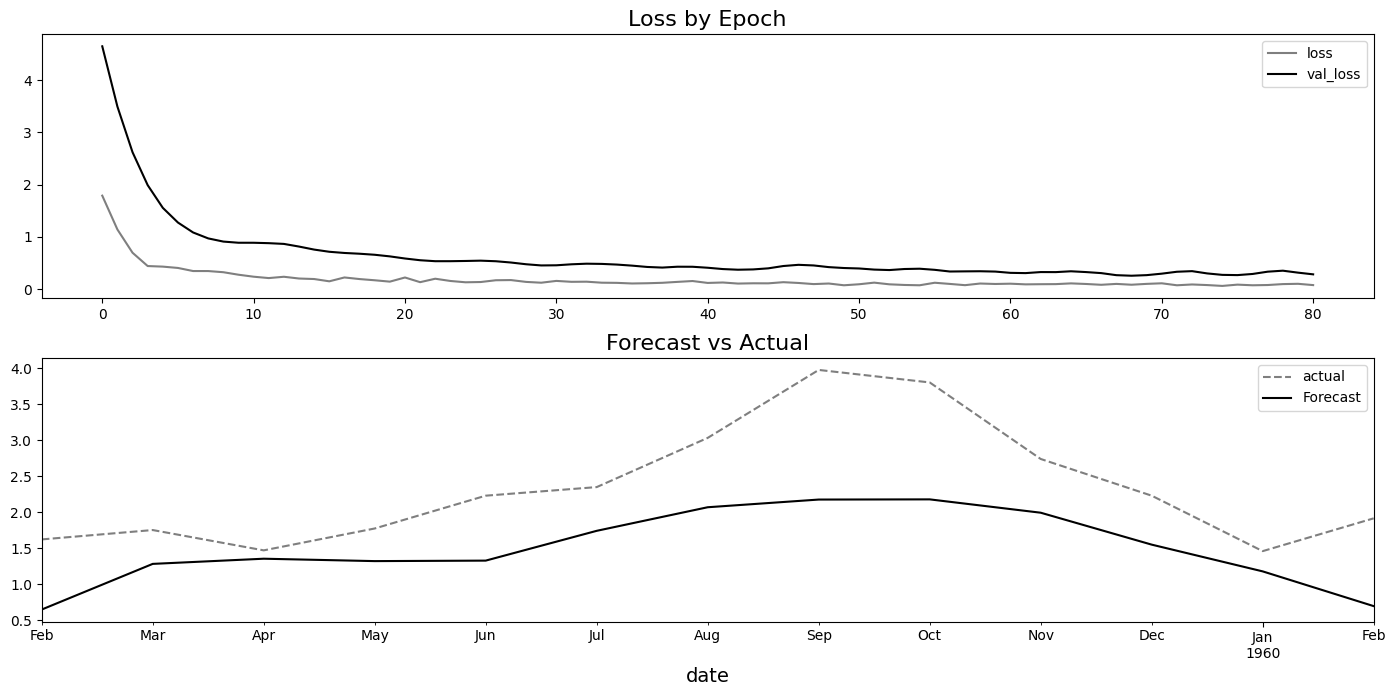

In [98]:
plot_forecast(model_a_simpleRNN, x_test_air, y_test_air, test_air.index, history_a_simpleRNN)

### Avg Daily Temp

In [101]:
tf.keras.backend.clear_session()

In [103]:
model_dw_simpleRNN = create_model(x_train_dw, units=32)

In [105]:
model_dw_simpleRNN.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn (SimpleRNN)          │ (None, 32)             │         1,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,121 (4.38 KB)

 Trainable params: 1,121 (4.38 KB)

 Non-trainable params: 0 (0.00 B)

In [107]:
history_dw_simpleRNN = train_model_ts(model_dw_simpleRNN, x_train_dw, y_train_dw, x_val_dw, y_val_dw, batch_size=64)

Epoch 1/500
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.7035 - mean_absolute_error: 0.6411 - root_mean_squared_error: 0.8377 - val_loss: 0.3908 - val_mean_absolute_error: 0.4869 - val_root_mean_squared_error: 0.6251
Epoch 2/500
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5341 - mean_absolute_error: 0.5259 - root_mean_squared_error: 0.7301 - val_loss: 0.3719 - val_mean_absolute_error: 0.4697 - val_root_mean_squared_error: 0.6098
Epoch 3/500
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4921 - mean_absolute_error: 0.4966 - root_mean_squared_error: 0.7005 - val_loss: 0.3780 - val_mean_absolute_error: 0.4698 - val_root_mean_squared_error: 0.6148
Epoch 4/500
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4930 - mean_absolute_error: 0.4858 - root_mean_squared_error: 0.7013 - val_loss: 0.3799 - val_mean_absolute_error: 0.4697 - val_root_mean_squared_error: 0.6163
Epoch 5/500
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4729 - mean_absolute_error: 0.4756 - root_mean_squared_

In [109]:
model_dw_simpleRNN.evaluate(x=x_test_dw, y=y_test_dw)

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3810 - mean_absolute_error: 0.4263 - root_mean_squared_error: 0.6157 


[0.3929795026779175, 0.6268807649612427, 0.44408661127090454]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


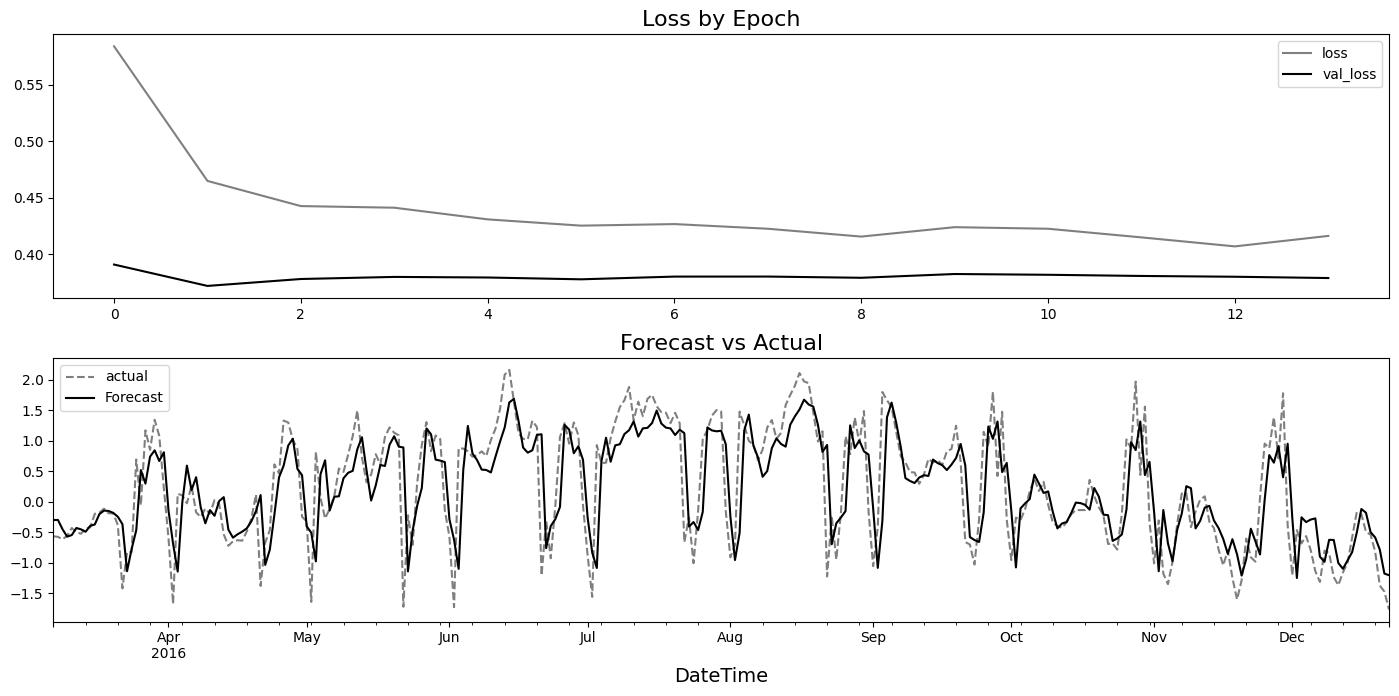

In [111]:
plot_forecast(model_dw_simpleRNN, x_test_dw, y_test_dw, test_dw.index, history_dw_simpleRNN)

### Energy Consumption

In [114]:
tf.keras.backend.clear_session()

In [116]:
model_en_simpleRNN = create_model(x_train_en, units=32)
model_en_simpleRNN.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn (SimpleRNN)          │ (None, 32)             │         1,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,121 (4.38 KB)

 Trainable params: 1,121 (4.38 KB)

 Non-trainable params: 0 (0.00 B)

In [118]:
history_en_simpleRNN = train_model_ts(model_en_simpleRNN, x_train_en, y_train_en, x_val_en, y_val_en, batch_size=64)

Epoch 1/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 1.6106 - mean_absolute_error: 1.0890 - root_mean_squared_error: 1.2667 - val_loss: 1.4805 - val_mean_absolute_error: 0.8960 - val_root_mean_squared_error: 1.2167
Epoch 2/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.0457 - mean_absolute_error: 0.8790 - root_mean_squared_error: 1.0192 - val_loss: 0.9886 - val_mean_absolute_error: 0.7402 - val_root_mean_squared_error: 0.9943
Epoch 3/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.7346 - mean_absolute_error: 0.7287 - root_mean_squared_error: 0.8550 - val_loss: 0.6653 - val_mean_absolute_error: 0.6242 - val_root_mean_squared_error: 0.8157
Epoch 4/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5139 - mean_absolute_error: 0.6030 - root_mean_squared_error: 0.7146 - val_loss: 0.4611 - val_mean_absolute_error: 0.5453 - val_root_mean_squared_error: 0.6791
Epoch 5/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4072 - mean_absolute_error: 0.5223 - root_mean_squared_error: 0.

In [119]:
model_en_simpleRNN.evaluate(x=x_test_en, y=y_test_en)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1153 - mean_absolute_error: 0.2620 - root_mean_squared_error: 0.3393


[0.10846812278032303, 0.3293449878692627, 0.2600082457065582]

In [120]:
y_test_air.shape

(13, 1)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


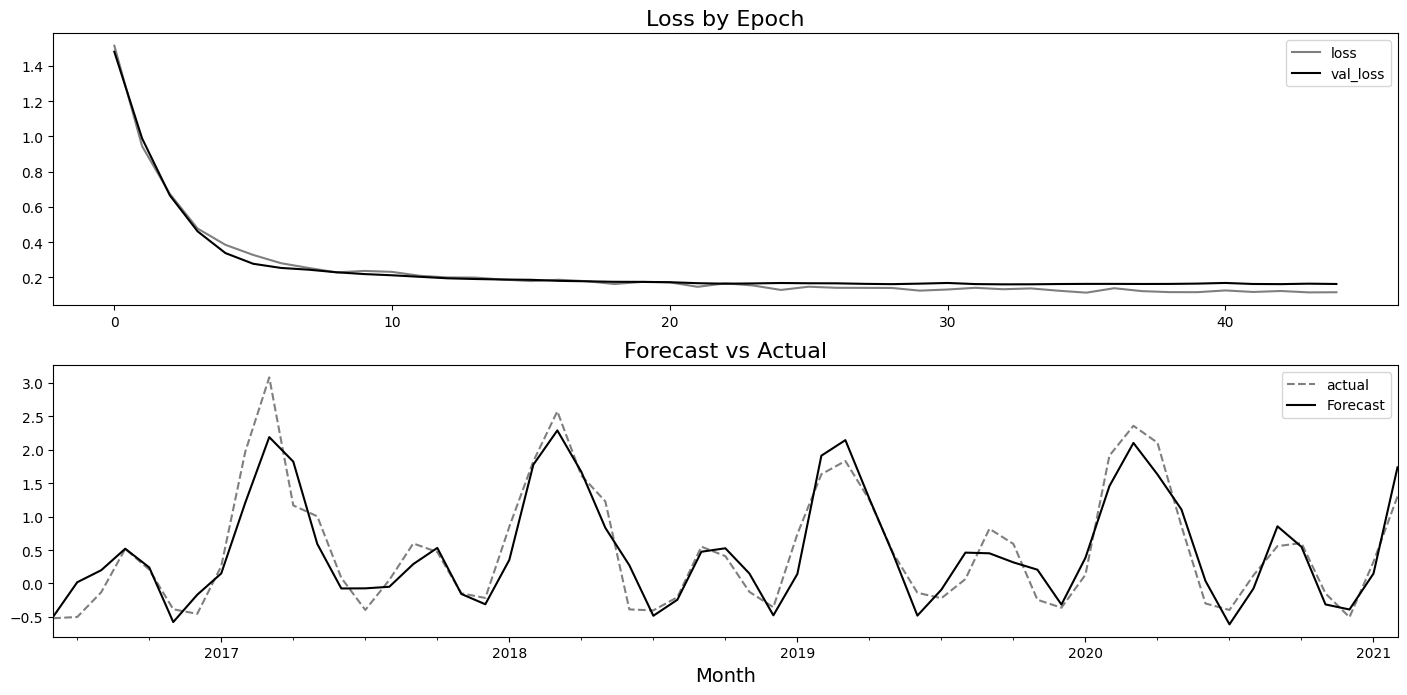

In [124]:
plot_forecast(model_en_simpleRNN, x_test_en, y_test_en, test_en.index, history_en_simpleRNN)

In [126]:
scale_en.inverse_y(y_test_en[0:5])

array([[1309.744],
       [1316.979],
       [1463.766],
       [1721.174],
       [1598.033]])

In [128]:
scale_en.inverse_y(model_en_simpleRNN.predict(x_test_en)[0:5])

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


array([[1319.04525046],
       [1523.0149105 ],
       [1594.53634335],
       [1721.96130719],
       [1610.99428992]])

In [130]:
def create_model(train, units, dropout=0.2):
    model = keras.Sequential()
    model.add(SimpleRNN(units=units,
                        return_sequences=False,
                        input_shape=(train.shape[1], 
                                     train.shape[2])))
    model.add(Dropout(dropout))
    model.add(keras.layers.Lin)
    
    return model

## LSTM

In [133]:
def create_model(train, units, dropout=0.2):
    model = keras.Sequential()
    model.add(LSTM(units=units,
                   input_shape=(train.shape[1], 
                                train.shape[2])))
    model.add(Dropout(dropout))
    model.add(Dense(1))
    
    return model

### Air Passenger

In [136]:
tf.keras.backend.clear_session()

In [138]:
model_a_lstm = create_model(train=x_train_air, units=32)
model_a_lstm.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 32)             │         4,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,385 (17.13 KB)

 Trainable params: 4,385 (17.13 KB)

 Non-trainable params: 0 (0.00 B)

In [140]:
history_a_lstm = train_model_ts(model_a_lstm, x_train_air, y_train_air, x_val_air, y_val_air)

Epoch 1/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 1.0656 - mean_absolute_error: 0.8952 - root_mean_squared_error: 1.0280 - val_loss: 3.9821 - val_mean_absolute_error: 1.8345 - val_root_mean_squared_error: 1.9955
Epoch 2/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.9017 - mean_absolute_error: 0.8155 - root_mean_squared_error: 0.9458 - val_loss: 3.4585 - val_mean_absolute_error: 1.6842 - val_root_mean_squared_error: 1.8597
Epoch 3/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.7657 - mean_absolute_error: 0.7484 - root_mean_squared_error: 0.8719 - val_loss: 2.9640 - val_mean_absolute_error: 1.5286 - val_root_mean_squared_error: 1.7216
Epoch 4/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.6536 - mean_absolute_error: 0.6758 - root_mean_squared_error: 0.8058 - val_loss: 2.5084 - val_mean_absolute_error: 1.3694 - val_root_mean_squared_error: 1.5838
Epoch 5/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.5385 - mean_absolute_error: 0.6054 - root_mean_squared_error:

In [141]:
model_a_lstm.evaluate(x=x_test_air, y=y_test_air)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 1.3111 - mean_absolute_error: 0.8438 - root_mean_squared_error: 1.1450


[1.311129093170166, 1.1450453996658325, 0.8438249230384827]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


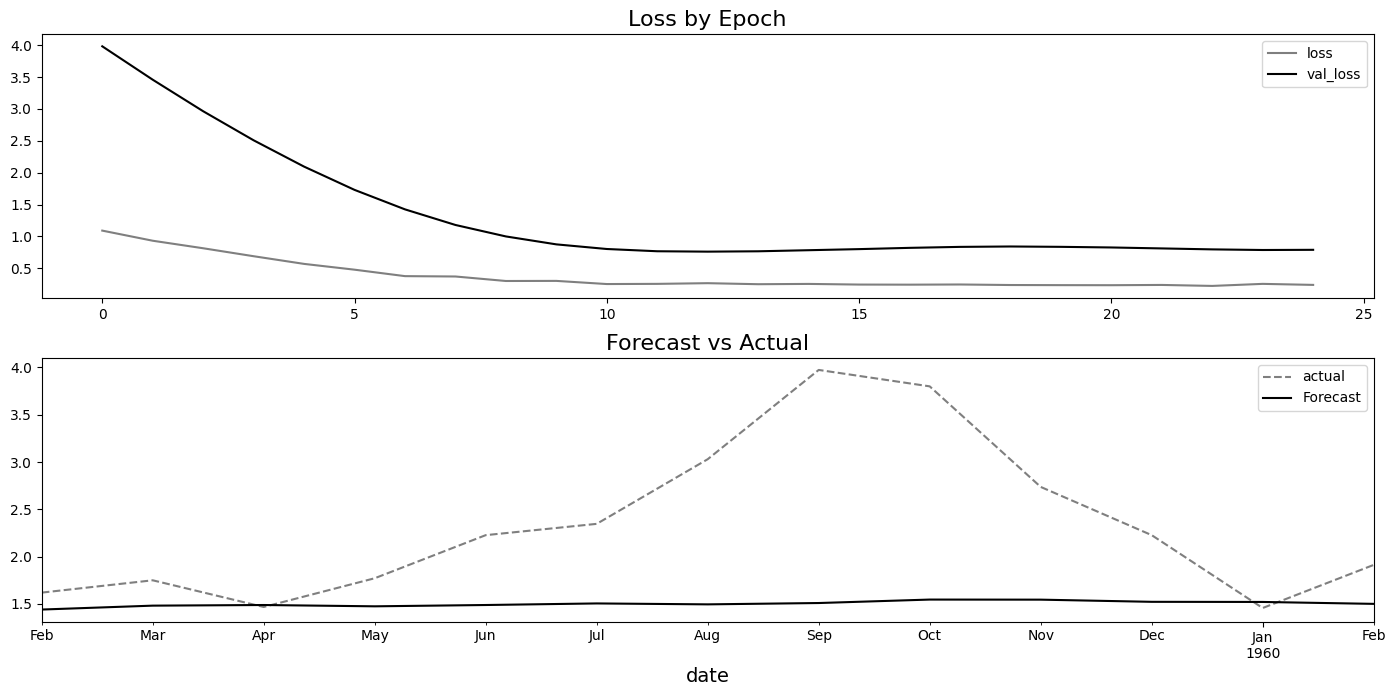

In [142]:
plot_forecast(model_a_lstm, x_test_air, y_test_air, test_air.index, history_a_lstm)

### Avg Daily Temp

In [144]:
tf.keras.backend.clear_session()

In [145]:
model_dw_lstm = create_model(train=x_train_dw, units=32)
model_dw_lstm.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 32)             │         4,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,385 (17.13 KB)

 Trainable params: 4,385 (17.13 KB)

 Non-trainable params: 0 (0.00 B)

In [149]:
history_dw_lstm = train_model_ts(model_dw_lstm, x_train_dw, y_train_dw, x_val_dw, y_val_dw, batch_size=64)

Epoch 1/500
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.0718 - mean_absolute_error: 0.8572 - root_mean_squared_error: 1.0343 - val_loss: 0.7103 - val_mean_absolute_error: 0.6907 - val_root_mean_squared_error: 0.8428
Epoch 2/500
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.8451 - mean_absolute_error: 0.7190 - root_mean_squared_error: 0.9188 - val_loss: 0.6362 - val_mean_absolute_error: 0.6416 - val_root_mean_squared_error: 0.7976
Epoch 3/500
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7767 - mean_absolute_error: 0.6772 - root_mean_squared_error: 0.8808 - val_loss: 0.5806 - val_mean_absolute_error: 0.6113 - val_root_mean_squared_error: 0.7620
Epoch 4/500
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7181 - mean_absolute_error: 0.6462 - root_mean_squared_error: 0.8469 - val_loss: 0.5348 - val_mean_absolute_error: 0.5862 - val_root_mean_squared_error: 0.7313
Epoch 5/500
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6632 - mean_absolute_error: 0.6152 - root_mean_squared_

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


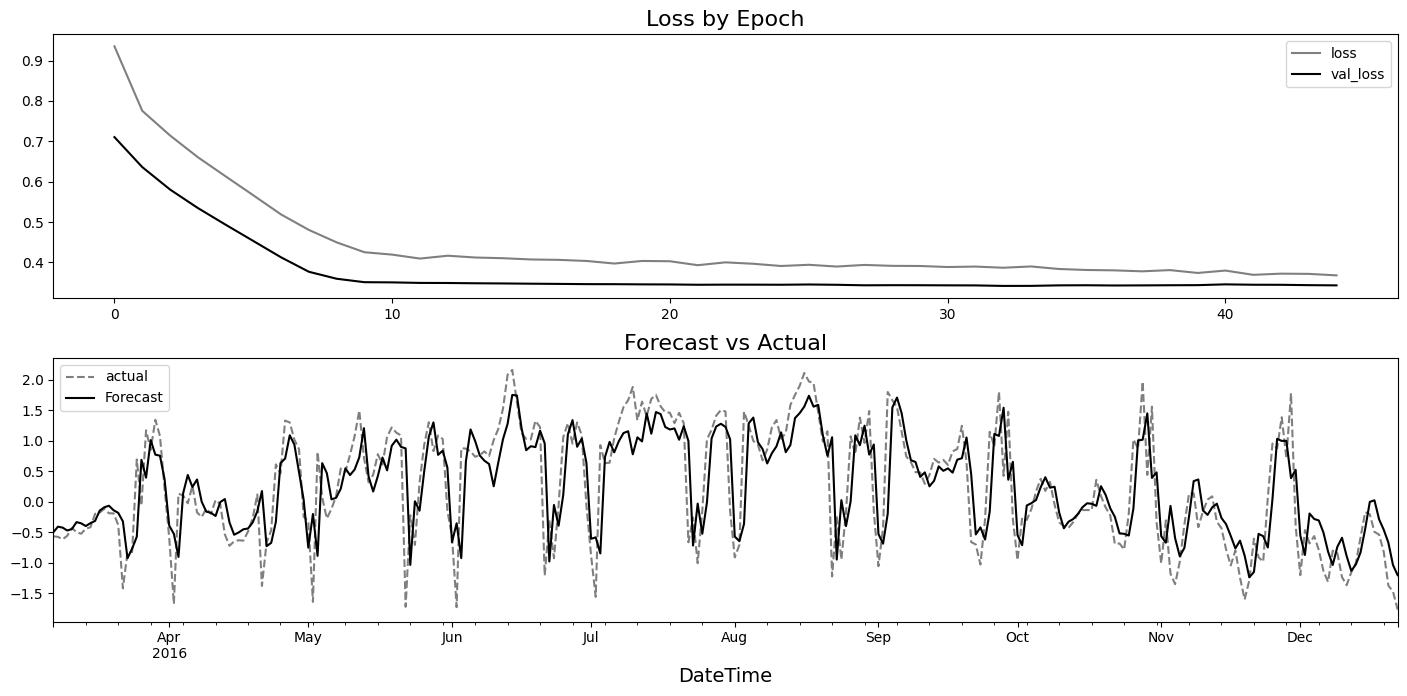

In [152]:
plot_forecast(model_dw_lstm, x_test_dw, y_test_dw, test_dw.index, history_dw_lstm)

### Energy Consumption

In [154]:
tf.keras.backend.clear_session()

In [155]:
model_en_lstm = create_model(train=x_train_en, units=32)
model_en_lstm.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 32)             │         4,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,385 (17.13 KB)

 Trainable params: 4,385 (17.13 KB)

 Non-trainable params: 0 (0.00 B)

In [156]:
history_en_lstm = train_model_ts(model_en_lstm, x_train_en, y_train_en, x_val_en, y_val_en, batch_size=64)

Epoch 1/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.9294 - mean_absolute_error: 0.8357 - root_mean_squared_error: 0.9634 - val_loss: 1.3082 - val_mean_absolute_error: 0.8466 - val_root_mean_squared_error: 1.1438
Epoch 2/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.8895 - mean_absolute_error: 0.8188 - root_mean_squared_error: 0.9425 - val_loss: 1.2701 - val_mean_absolute_error: 0.8388 - val_root_mean_squared_error: 1.1270
Epoch 3/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.8575 - mean_absolute_error: 0.8041 - root_mean_squared_error: 0.9255 - val_loss: 1.2322 - val_mean_absolute_error: 0.8310 - val_root_mean_squared_error: 1.1100
Epoch 4/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.8359 - mean_absolute_error: 0.7920 - root_mean_squared_error: 0.9137 - val_loss: 1.1968 - val_mean_absolute_error: 0.8241 - val_root_mean_squared_error: 1.0940
Epoch 5/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.8219 - mean_absolute_error: 0.7822 - root_mean_squared_error: 0.

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


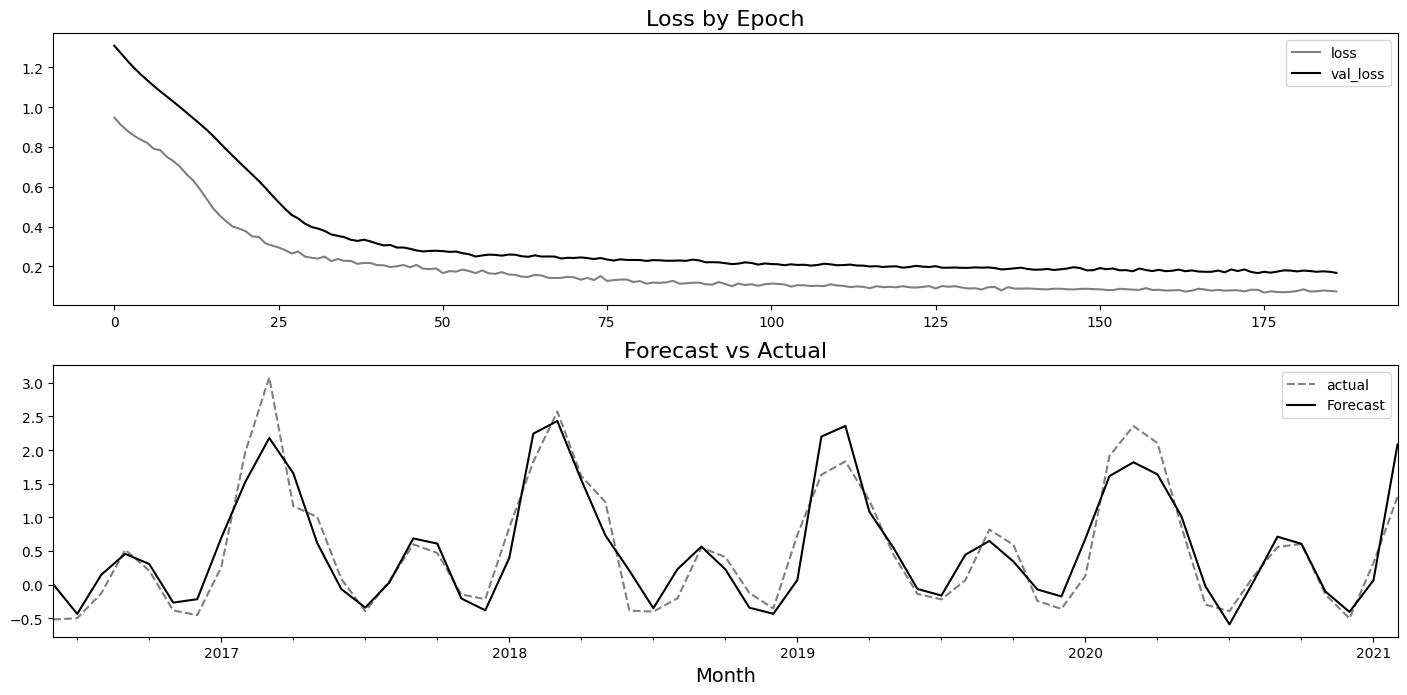

In [157]:
plot_forecast(model_en_lstm, x_test_en, y_test_en, test_en.index, history_en_lstm)

## GRU

In [159]:
def create_model(train, units, dropout=0.2):
    model = keras.Sequential()
    model.add(GRU(units=units,
                  input_shape=(train.shape[1], 
                               train.shape[2])))
    model.add(Dropout(dropout))
    model.add(Dense(1))
    
    return model

### Air Passenger

In [162]:
tf.keras.backend.clear_session()

In [163]:
model_a_gru = create_model(train=x_train_air, units=32)
history_a_gru = train_model_ts(model_a_gru, x_train_air, y_train_air, x_val_air, y_val_air)


Epoch 1/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 0.6163 - mean_absolute_error: 0.6525 - root_mean_squared_error: 0.7823 - val_loss: 2.2575 - val_mean_absolute_error: 1.3097 - val_root_mean_squared_error: 1.5025
Epoch 2/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.4928 - mean_absolute_error: 0.5810 - root_mean_squared_error: 0.6996 - val_loss: 1.8362 - val_mean_absolute_error: 1.1413 - val_root_mean_squared_error: 1.3551
Epoch 3/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.3699 - mean_absolute_error: 0.4944 - root_mean_squared_error: 0.6055 - val_loss: 1.4657 - val_mean_absolute_error: 0.9684 - val_root_mean_squared_error: 1.2107
Epoch 4/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.3235 - mean_absolute_error: 0.4476 - root_mean_squared_error: 0.5661 - val_loss: 1.1619 - val_mean_absolute_error: 0.8272 - val_root_mean_squared_error: 1.0779
Epoch 5/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.2744 - mean_absolute_error: 0.4077 - root_mean_squared_error: 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


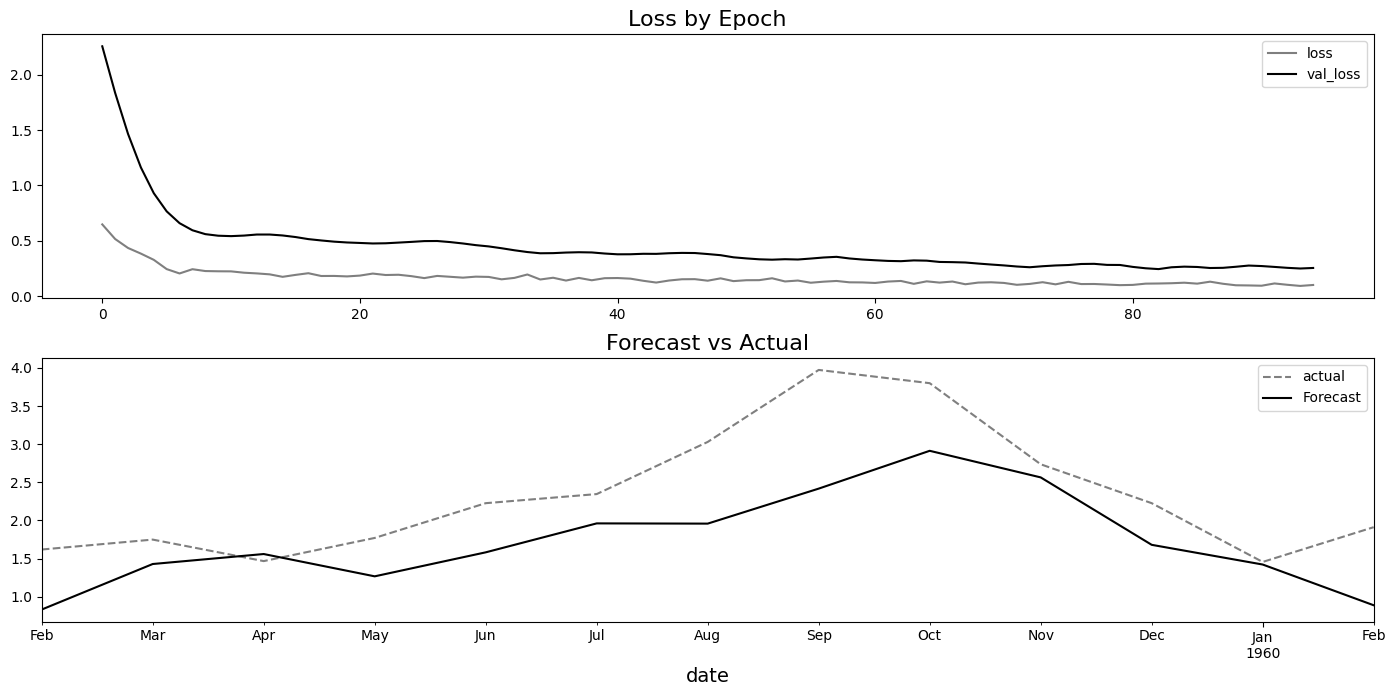

In [166]:
plot_forecast(model_a_gru, x_test_air, y_test_air, test_air.index, history_a_gru)

### Avg Daily Temp

In [169]:
tf.keras.backend.clear_session()

In [170]:
model_dw_gru = create_model(train=x_train_dw, units=32)
history_dw_gru = train_model_ts(model_dw_gru, x_train_dw, y_train_dw, x_val_dw, y_val_dw, batch_size=64)

Epoch 1/500
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.2714 - mean_absolute_error: 0.9352 - root_mean_squared_error: 1.1255 - val_loss: 0.6810 - val_mean_absolute_error: 0.6822 - val_root_mean_squared_error: 0.8252
Epoch 2/500
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.7906 - mean_absolute_error: 0.7044 - root_mean_squared_error: 0.8886 - val_loss: 0.5318 - val_mean_absolute_error: 0.5818 - val_root_mean_squared_error: 0.7292
Epoch 3/500
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6679 - mean_absolute_error: 0.6123 - root_mean_squared_error: 0.8166 - val_loss: 0.4720 - val_mean_absolute_error: 0.5473 - val_root_mean_squared_error: 0.6870
Epoch 4/500
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6069 - mean_absolute_error: 0.5789 - root_mean_squared_error: 0.7785 - val_loss: 0.4303 - val_mean_absolute_error: 0.5210 - val_root_mean_squared_error: 0.6560
Epoch 5/500
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5524 - mean_absolute_error: 0.5453 - root_mean_squared_

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


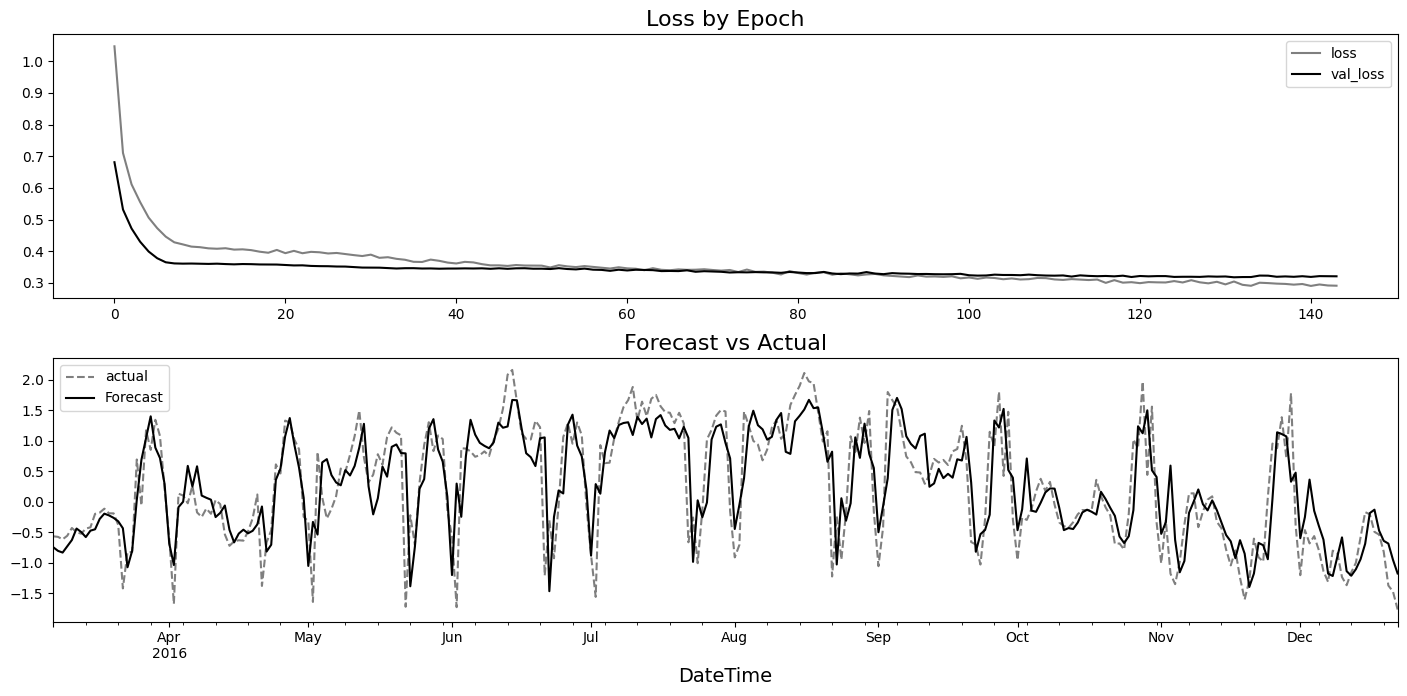

In [171]:
plot_forecast(model_dw_gru, x_test_dw, y_test_dw, test_dw.index, history_dw_gru)

### Energy Consumption

In [173]:
tf.keras.backend.clear_session()

In [174]:
model_en_gru = create_model(x_train_en, units=32)
model_en_gru.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru (GRU)                       │ (None, 32)             │         3,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,393 (13.25 KB)

 Trainable params: 3,393 (13.25 KB)

 Non-trainable params: 0 (0.00 B)

In [175]:
history_en_gru = train_model_ts(model_en_gru, x_train_en, y_train_en, x_val_en, y_val_en, batch_size=64)

Epoch 1/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 1.0871 - mean_absolute_error: 0.8918 - root_mean_squared_error: 1.0412 - val_loss: 1.3980 - val_mean_absolute_error: 0.8525 - val_root_mean_squared_error: 1.1824
Epoch 2/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.9690 - mean_absolute_error: 0.8451 - root_mean_squared_error: 0.9834 - val_loss: 1.3056 - val_mean_absolute_error: 0.8392 - val_root_mean_squared_error: 1.1426
Epoch 3/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.9328 - mean_absolute_error: 0.8388 - root_mean_squared_error: 0.9648 - val_loss: 1.2240 - val_mean_absolute_error: 0.8227 - val_root_mean_squared_error: 1.1064
Epoch 4/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.8615 - mean_absolute_error: 0.7999 - root_mean_squared_error: 0.9274 - val_loss: 1.1549 - val_mean_absolute_error: 0.8066 - val_root_mean_squared_error: 1.0747
Epoch 5/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.8216 - mean_absolute_error: 0.7800 - root_mean_squared_error: 0.

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


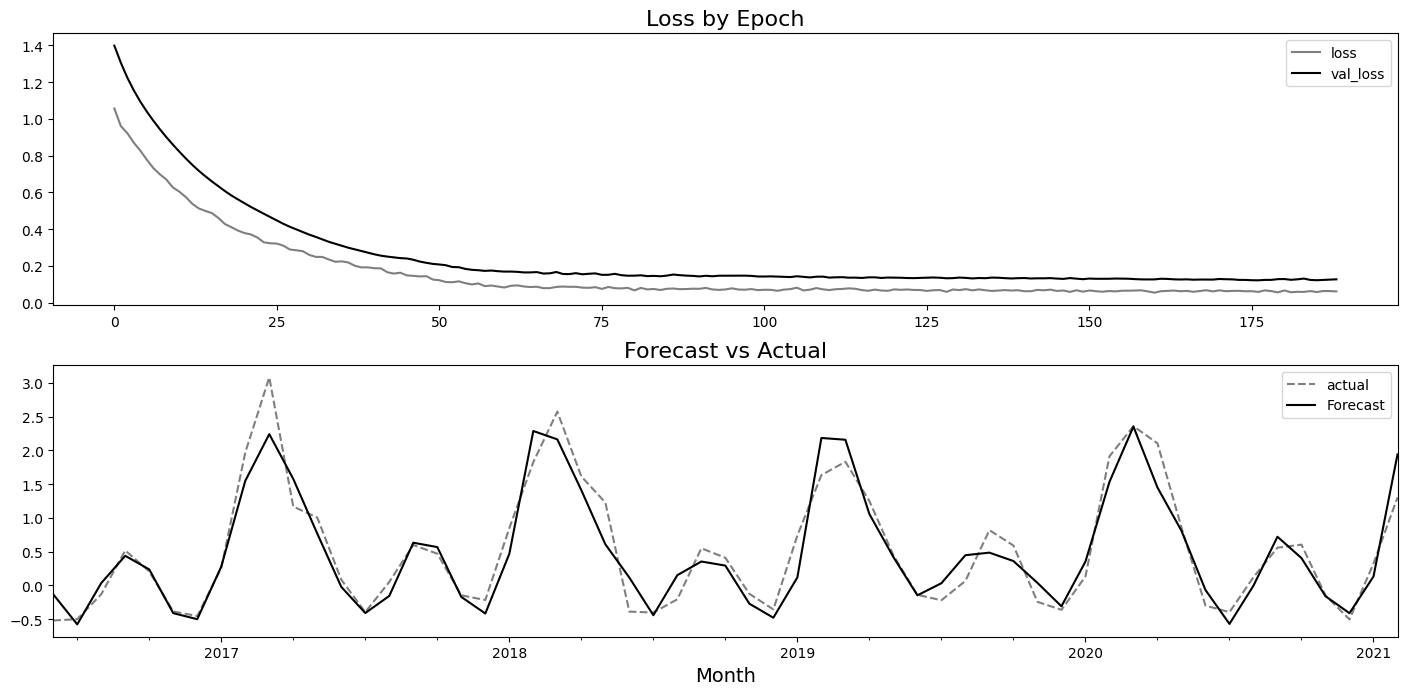

In [176]:
plot_forecast(model_en_gru, x_test_en, y_test_en, test_en.index, history_en_gru)

## Deep RNN-LSTM

### Air Passenger

In [179]:
tf.keras.backend.clear_session()

In [180]:
def create_model(train, units, dropout=0.2):
    model = keras.Sequential()
    model.add(LSTM(units=units,input_shape=(train.shape[1], train.shape[2]), return_sequences=True))
    model.add(Dropout(dropout))
    model.add(LSTM(units=units))
    model.add(Dropout(dropout))
    model.add(Dense(1))
    
    return model

In [181]:
model_a_deep = create_model(train=x_train_air, units=32)
history_a_deep = train_model_ts(model_a_deep, x_train_air, y_train_air, x_val_air, y_val_air)

Epoch 1/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - loss: 1.1043 - mean_absolute_error: 0.9105 - root_mean_squared_error: 1.0462 - val_loss: 4.0218 - val_mean_absolute_error: 1.8483 - val_root_mean_squared_error: 2.0054
Epoch 2/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.9005 - mean_absolute_error: 0.8199 - root_mean_squared_error: 0.9452 - val_loss: 3.4594 - val_mean_absolute_error: 1.6859 - val_root_mean_squared_error: 1.8600
Epoch 3/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.7812 - mean_absolute_error: 0.7542 - root_mean_squared_error: 0.8805 - val_loss: 2.9416 - val_mean_absolute_error: 1.5209 - val_root_mean_squared_error: 1.7151
Epoch 4/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.6686 - mean_absolute_error: 0.6889 - root_mean_squared_error: 0.8149 - val_loss: 2.4517 - val_mean_absolute_error: 1.3460 - val_root_mean_squared_error: 1.5658
Epoch 5/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.5490 - mean_absolute_error: 0.6182 - root_mean_squared_error

In [182]:
model_a_deep.evaluate(x_test_air, y_test_air)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 1.4352 - mean_absolute_error: 0.8857 - root_mean_squared_error: 1.1980


[1.4352138042449951, 1.198004126548767, 0.8856656551361084]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


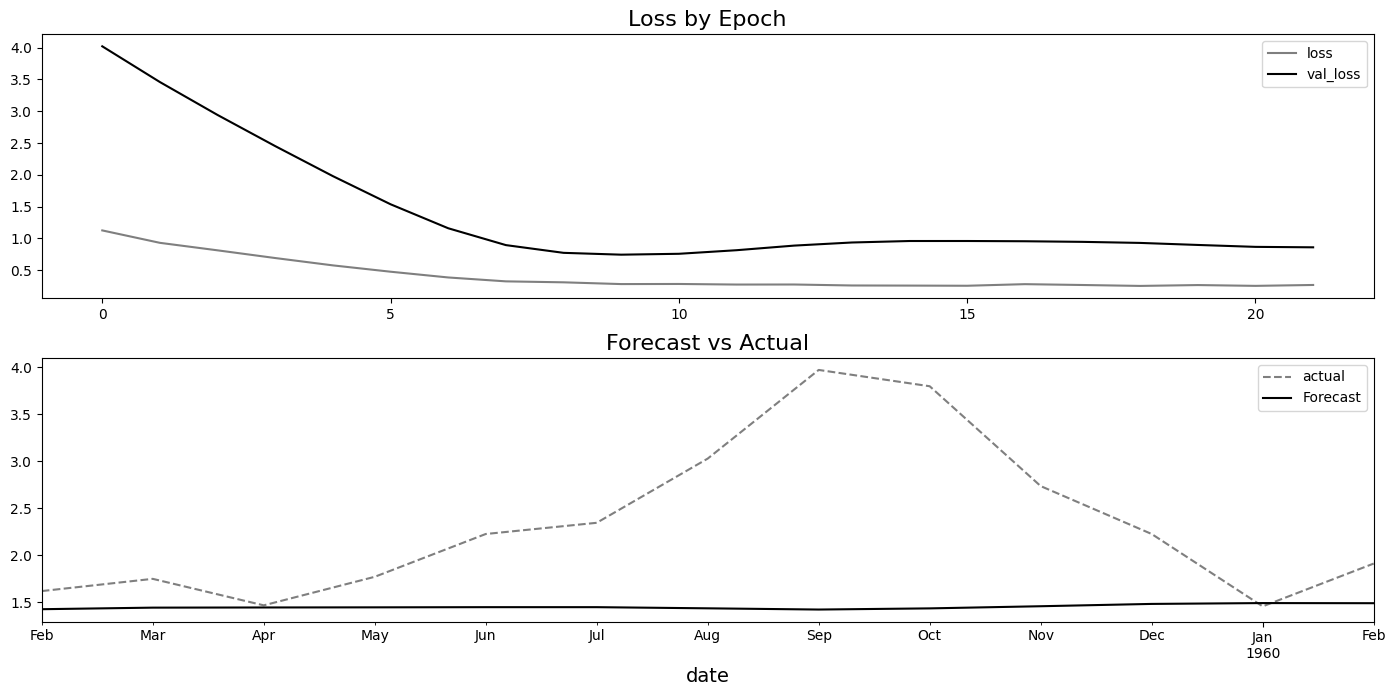

In [183]:
plot_forecast(model_a_deep, x_test_air, y_test_air, test_air.index, history_a_deep)

### Avg Daily Temp

In [185]:
tf.keras.backend.clear_session()

Epoch 1/500
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 1.0173 - mean_absolute_error: 0.8342 - root_mean_squared_error: 1.0078 - val_loss: 0.7291 - val_mean_absolute_error: 0.6945 - val_root_mean_squared_error: 0.8539
Epoch 2/500
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.8750 - mean_absolute_error: 0.7297 - root_mean_squared_error: 0.9349 - val_loss: 0.6811 - val_mean_absolute_error: 0.6689 - val_root_mean_squared_error: 0.8253
Epoch 3/500
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.8293 - mean_absolute_error: 0.7081 - root_mean_squared_error: 0.9102 - val_loss: 0.6329 - val_mean_absolute_error: 0.6422 - val_root_mean_squared_error: 0.7956
Epoch 4/500
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.7746 - mean_absolute_error: 0.6798 - root_mean_squared_error: 0.8797 - val_loss: 0.5718 - val_mean_absolute_error: 0.6056 - val_root_mean_squared_error: 0.7562
Epoch 5/500
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6962 - mean_absolute_error: 0.6370 - root_mean_squared_

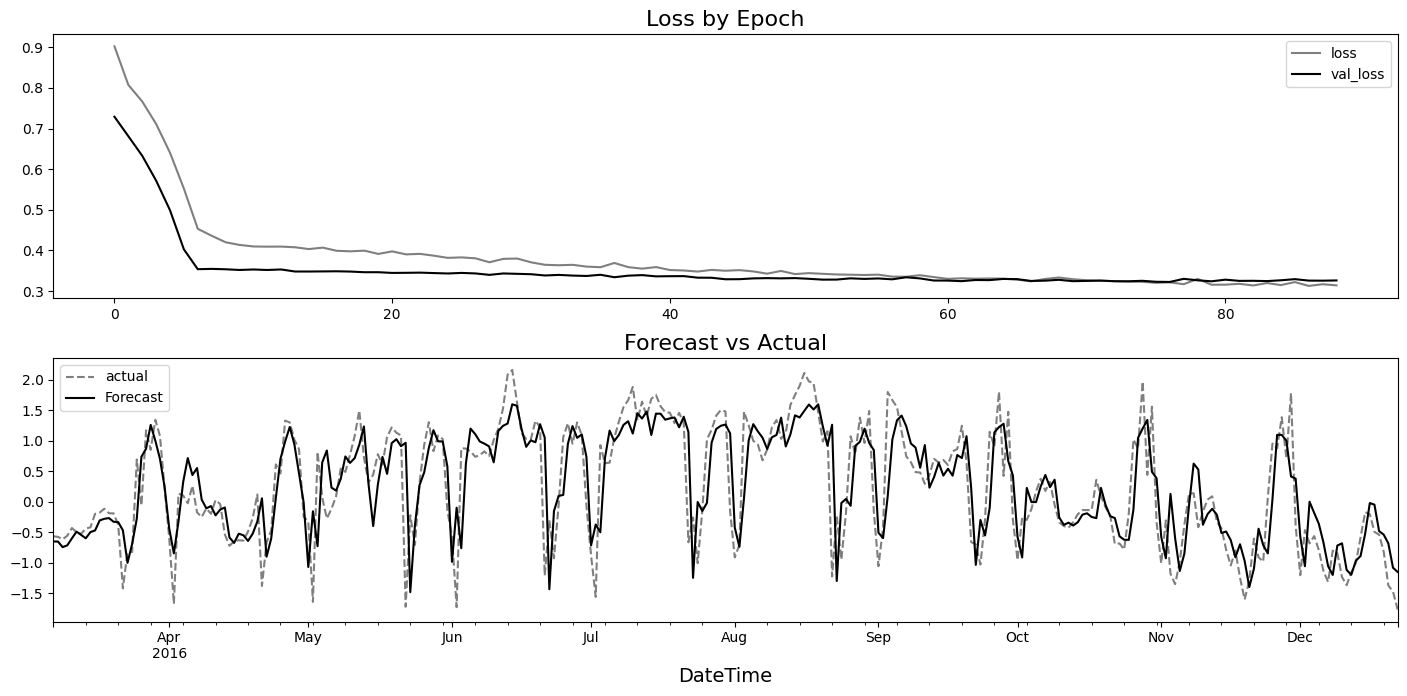

In [186]:
model_dw_deep = create_model(x_train_dw, units=32)
history_dw_deep = train_model_ts(model_dw_deep, x_train_dw, y_train_dw, x_val_dw, y_val_dw, batch_size=64)
plot_forecast(model_dw_deep, x_test_dw, y_test_dw, test_dw.index, history_dw_deep)

### Energy Consumption

In [188]:
tf.keras.backend.clear_session()

Epoch 1/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 1.0511 - mean_absolute_error: 0.8762 - root_mean_squared_error: 1.0239 - val_loss: 1.4313 - val_mean_absolute_error: 0.8605 - val_root_mean_squared_error: 1.1964
Epoch 2/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.9958 - mean_absolute_error: 0.8622 - root_mean_squared_error: 0.9970 - val_loss: 1.3886 - val_mean_absolute_error: 0.8617 - val_root_mean_squared_error: 1.1784
Epoch 3/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.9815 - mean_absolute_error: 0.8608 - root_mean_squared_error: 0.9900 - val_loss: 1.3569 - val_mean_absolute_error: 0.8630 - val_root_mean_squared_error: 1.1649
Epoch 4/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.9764 - mean_absolute_error: 0.8607 - root_mean_squared_error: 0.9874 - val_loss: 1.3340 - val_mean_absolute_error: 0.8631 - val_root_mean_squared_error: 1.1550
Epoch 5/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.9688 - mean_absolute_error: 0.8599 - root_mean_squared_error: 0.

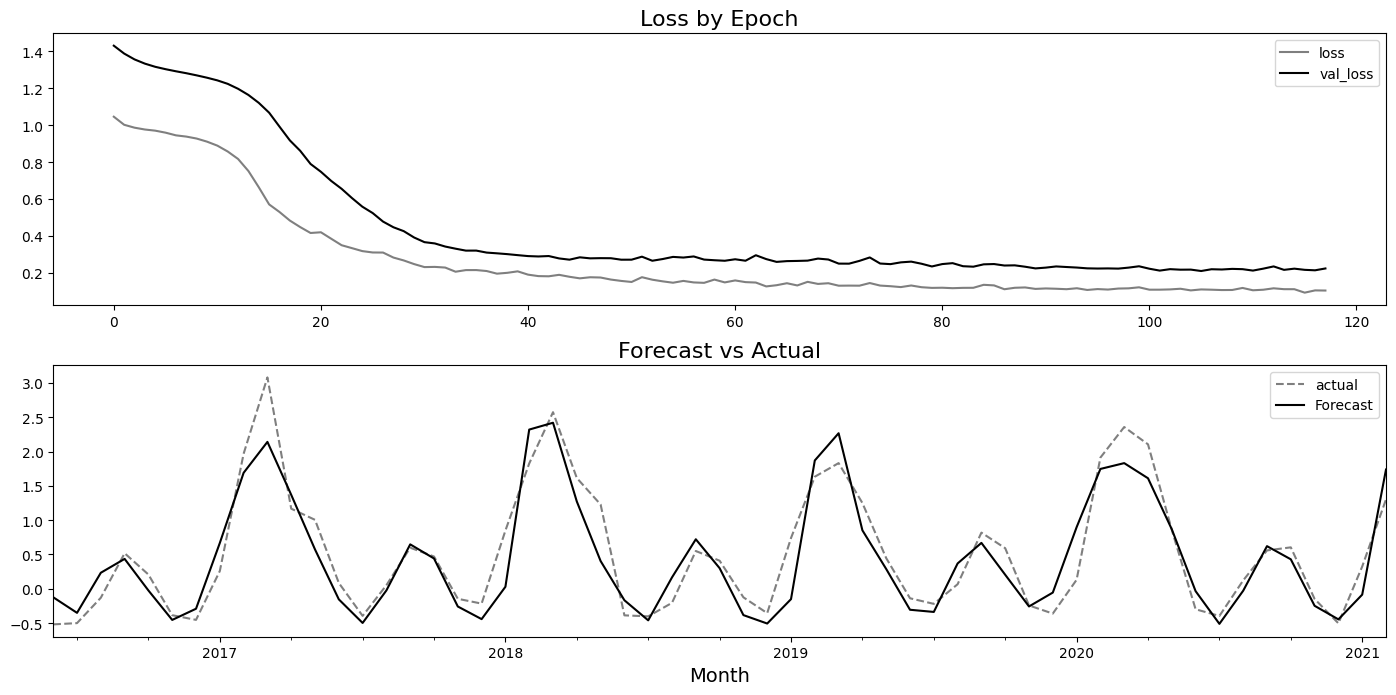

In [189]:
model_en_deep = create_model(x_train_en, units=32)
history_en_deep = train_model_ts(model_en_deep, x_train_en, y_train_en, x_val_en, y_val_en, batch_size=64)
plot_forecast(model_en_deep, x_test_en, y_test_en, test_en.index, history_en_deep)

## Bidirectional

In [191]:
def create_model(train, units, dropout=0.2):
    model = keras.Sequential()
    model.add(Bidirectional(LSTM(units=units, 
                                 input_shape=(train.shape[1], train.shape[2]), return_sequences=True)))
    model.add(Bidirectional(LSTM(units=units, return_sequences=False)))
    model.add(Dropout(dropout))
    model.add(Dense(1))
    
    return model

### Air Passenger

In [193]:
tf.keras.backend.clear_session()

In [194]:
model_a_bd = create_model(train=x_train_air, units=32)
history_a_bd = train_model_ts(model_a_bd, x_train_air, y_train_air, x_val_air, y_val_air)

Epoch 1/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 90ms/step - loss: 0.8881 - mean_absolute_error: 0.8098 - root_mean_squared_error: 0.9385 - val_loss: 2.9905 - val_mean_absolute_error: 1.5391 - val_root_mean_squared_error: 1.7293
Epoch 2/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.5977 - mean_absolute_error: 0.6489 - root_mean_squared_error: 0.7705 - val_loss: 2.1184 - val_mean_absolute_error: 1.2184 - val_root_mean_squared_error: 1.4555
Epoch 3/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.3831 - mean_absolute_error: 0.5042 - root_mean_squared_error: 0.6171 - val_loss: 1.3914 - val_mean_absolute_error: 0.8712 - val_root_mean_squared_error: 1.1796
Epoch 4/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.2319 - mean_absolute_error: 0.3793 - root_mean_squared_error: 0.4777 - val_loss: 0.8908 - val_mean_absolute_error: 0.7039 - val_root_mean_squared_error: 0.9438
Epoch 5/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.1781 - mean_absolute_error: 0.3209 - root_mean_squared_error

In [195]:
model_a_bd.evaluate(x=x_test_air, y=y_test_air)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 1.1419 - mean_absolute_error: 0.7722 - root_mean_squared_error: 1.0686


[1.1419041156768799, 1.0685991048812866, 0.7721871733665466]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


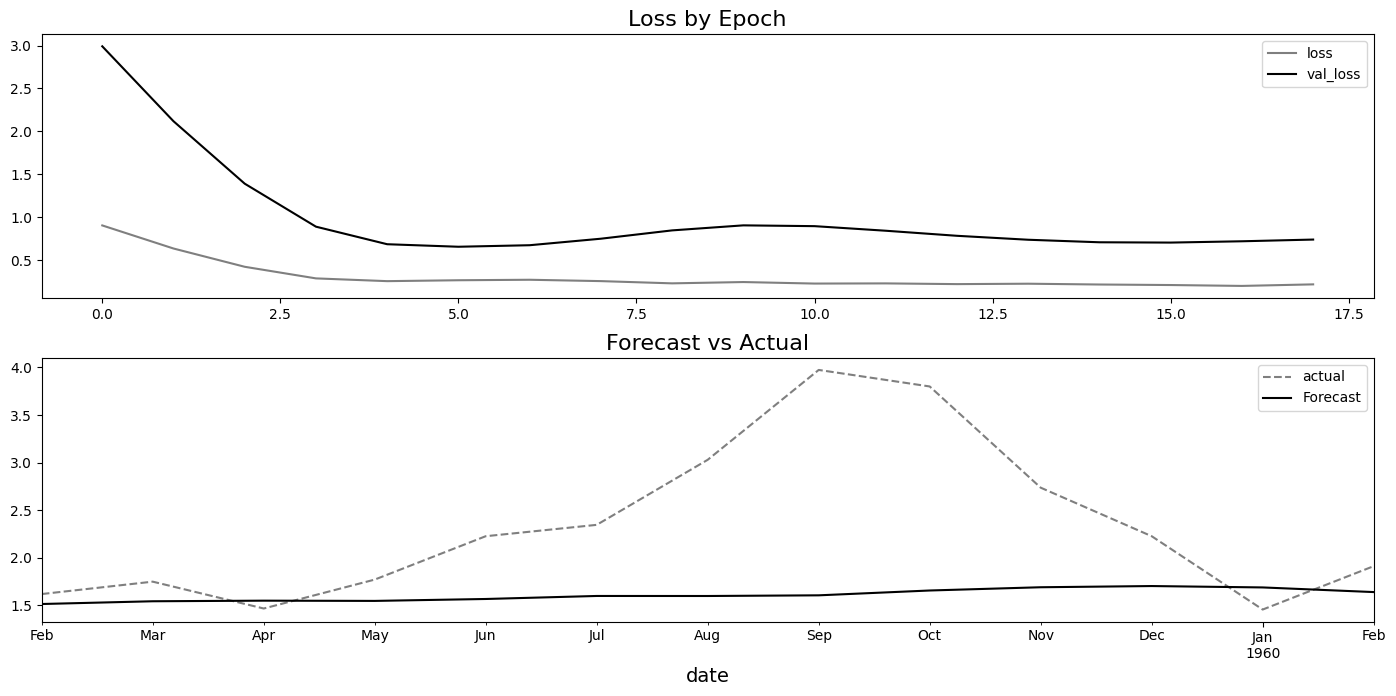

In [196]:
plot_forecast(model_a_bd, x_test_air, y_test_air, test_air.index, history_a_bd)

### Avd Daily Temp

In [199]:
tf.keras.backend.clear_session()

In [202]:
model_dw_bd = create_model(x_train_dw, units=32)
history_dw_bd = train_model_ts(model_dw_bd, x_train_dw, y_train_dw, x_val_dw, y_val_dw, batch_size=64)

Epoch 1/500
37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.9006 - mean_absolute_error: 0.7613 - root_mean_squared_error: 0.9481 - val_loss: 0.5861 - val_mean_absolute_error: 0.6062 - val_root_mean_squared_error: 0.7656
Epoch 2/500
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.7216 - mean_absolute_error: 0.6381 - root_mean_squared_error: 0.8490 - val_loss: 0.4842 - val_mean_absolute_error: 0.5477 - val_root_mean_squared_error: 0.6958
Epoch 3/500
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.6126 - mean_absolute_error: 0.5746 - root_mean_squared_error: 0.7821 - val_loss: 0.4160 - val_mean_absolute_error: 0.5067 - val_root_mean_squared_error: 0.6450
Epoch 4/500
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.5320 - mean_absolute_error: 0.5250 - root_mean_squared_error: 0.7286 - val_loss: 0.3734 - val_mean_absolute_error: 0.4732 - val_root_mean_squared_error: 0.6111
Epoch 5/500
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.4815 - mean_absolute_error: 0.4981 - root_mean_squared

In [204]:
x_test_dw.shape

(291, 10, 1)

In [205]:
model_dw_bd.predict(x_test_dw).shape

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step 


(291, 1)

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


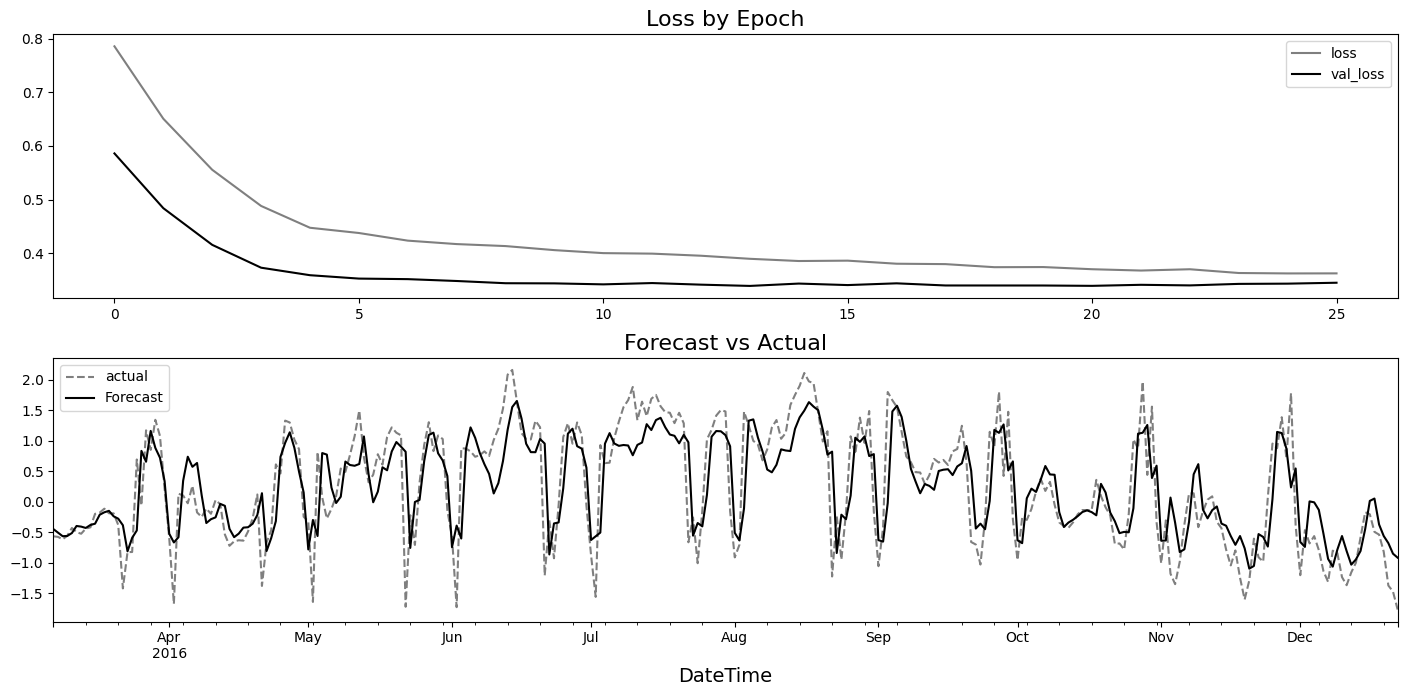

In [206]:
plot_forecast(model_dw_bd, x_test_dw, y_test_dw, test_dw.index, history_dw_bd)

### Energy Consumption

In [208]:
tf.keras.backend.clear_session()

Epoch 1/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - loss: 1.0021 - mean_absolute_error: 0.8687 - root_mean_squared_error: 1.0001 - val_loss: 1.3187 - val_mean_absolute_error: 0.8600 - val_root_mean_squared_error: 1.1483
Epoch 2/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.9146 - mean_absolute_error: 0.8313 - root_mean_squared_error: 0.9558 - val_loss: 1.2464 - val_mean_absolute_error: 0.8542 - val_root_mean_squared_error: 1.1164
Epoch 3/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.8631 - mean_absolute_error: 0.8065 - root_mean_squared_error: 0.9286 - val_loss: 1.1887 - val_mean_absolute_error: 0.8422 - val_root_mean_squared_error: 1.0903
Epoch 4/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.8079 - mean_absolute_error: 0.7725 - root_mean_squared_error: 0.8984 - val_loss: 1.1363 - val_mean_absolute_error: 0.8263 - val_root_mean_squared_error: 1.0660
Epoch 5/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.7382 - mean_absolute_error: 0.7309 - root_mean_squared_error: 0.

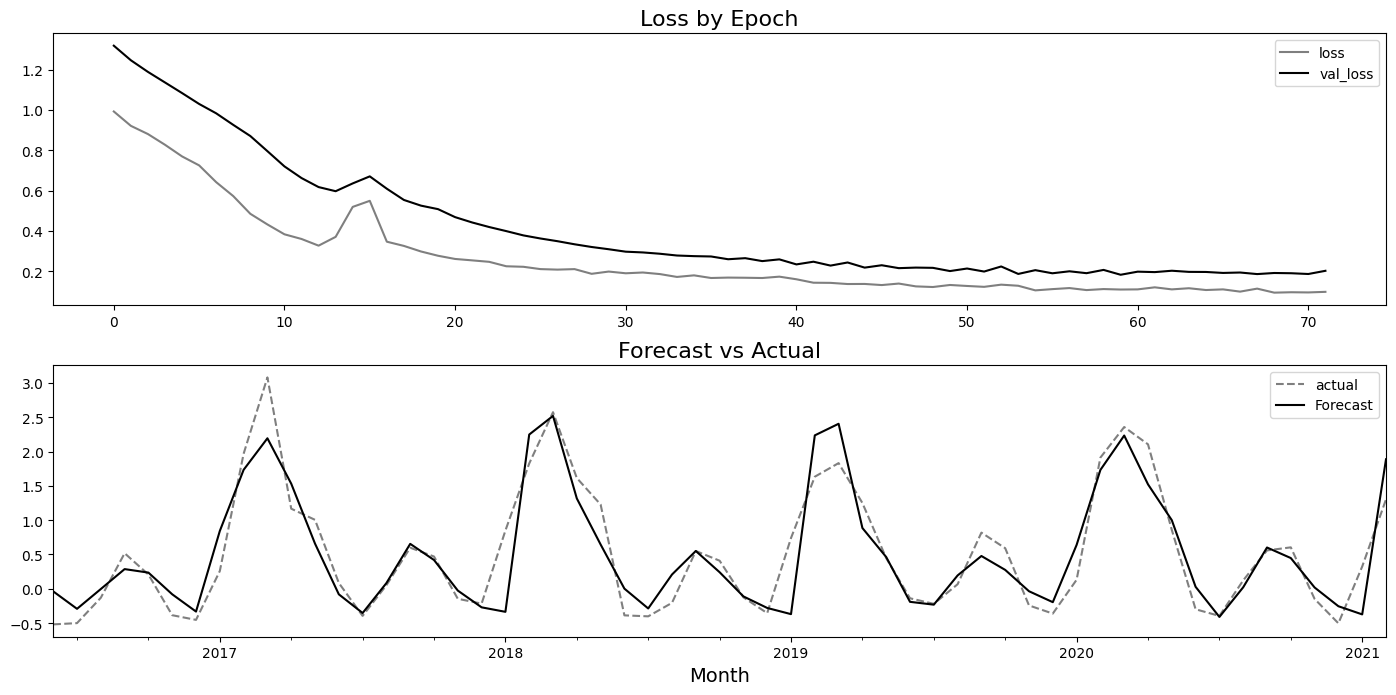

In [209]:
model_en_bd = create_model(x_train_en, units=32)
history_en_bd = train_model_ts(model_en_bd, x_train_en, y_train_en, x_val_en, y_val_en, batch_size=64)
plot_forecast(model_en_bd, x_test_en, y_test_en, test_en.index, history_en_bd)

## Timedistributed

In [240]:
def create_model(train, units, dropout=0.2):
    model = keras.Sequential()
    model.add(LSTM(units=units, input_shape=(train.shape[1], train.shape[2]), return_sequences=True))
    model.add(LSTM(units=units, return_sequences=True))
    model.add(TimeDistributed(Dense(1)))
    
    return model

### Air Passenger

In [243]:
tf.keras.backend.clear_session()

In [245]:
model_a_td = create_model(train=x_train_air, units=32)
history_a_td = train_model_ts(model_a_td, x_train_air, y_train_air, x_val_air, y_val_air)

Epoch 1/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - loss: 0.9684 - mean_absolute_error: 0.8497 - root_mean_squared_error: 0.9801 - val_loss: 3.8234 - val_mean_absolute_error: 1.7956 - val_root_mean_squared_error: 1.9553
Epoch 2/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.8692 - mean_absolute_error: 0.8009 - root_mean_squared_error: 0.9287 - val_loss: 3.5045 - val_mean_absolute_error: 1.6998 - val_root_mean_squared_error: 1.8720
Epoch 3/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.7927 - mean_absolute_error: 0.7604 - root_mean_squared_error: 0.8870 - val_loss: 3.1797 - val_mean_absolute_error: 1.5938 - val_root_mean_squared_error: 1.7832
Epoch 4/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.7186 - mean_absolute_error: 0.7181 - root_mean_squared_error: 0.8447 - val_loss: 2.8485 - val_mean_absolute_error: 1.4739 - val_root_mean_squared_error: 1.6877
Epoch 5/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.6451 - mean_absolute_error: 0.6730 - root_mean_squared_error

In [246]:
model_a_td.evaluate(x=x_test_air, y=y_test_air)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 2.2787 - mean_absolute_error: 1.3177 - root_mean_squared_error: 1.5095


[2.278672933578491, 1.5095274448394775, 1.317659616470337]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


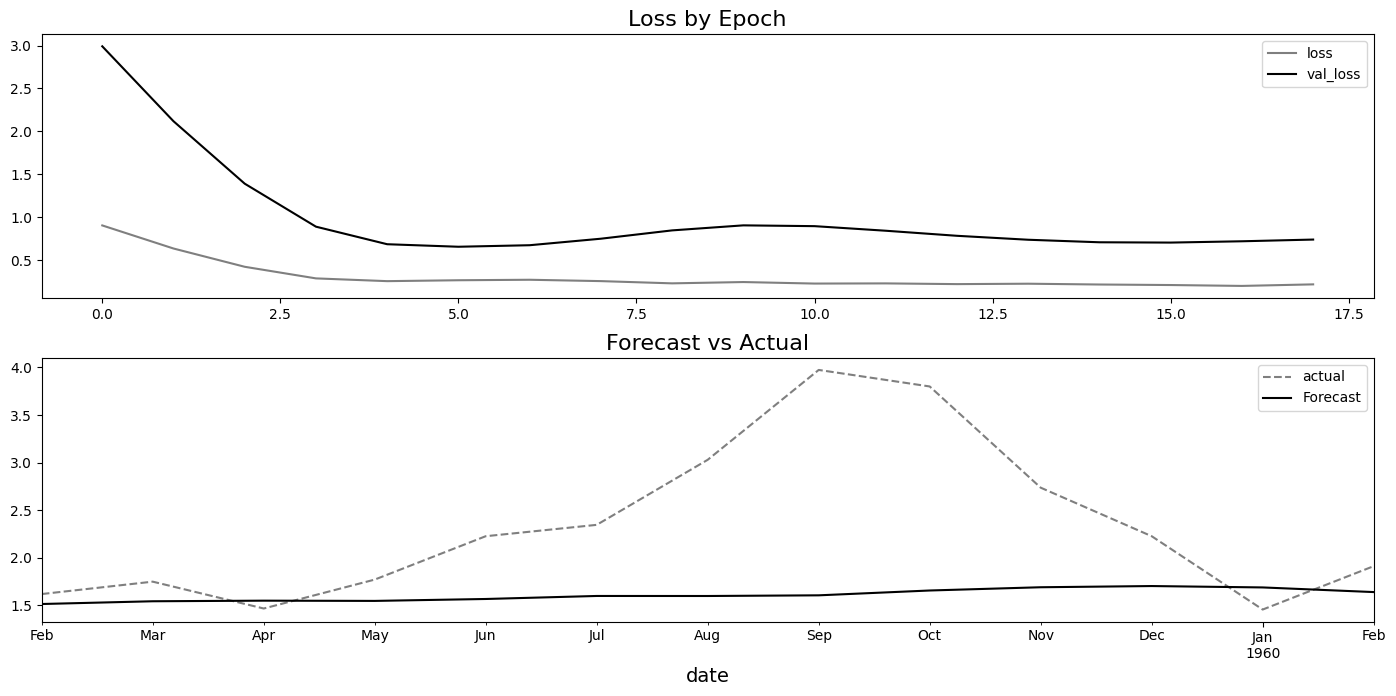

In [247]:
plot_forecast(model_a_bd, x_test_air, y_test_air, test_air.index, history_a_bd)

### Avd Daily Temp

In [252]:
tf.keras.backend.clear_session()

In [254]:
model_dw_td = create_model(x_train_dw, units=32)
history_dw_td = train_model_ts(model_dw_td, x_train_dw, y_train_dw, x_val_dw, y_val_dw, batch_size=64)

Epoch 1/500
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 1.0116 - mean_absolute_error: 0.8292 - root_mean_squared_error: 1.0052 - val_loss: 0.8274 - val_mean_absolute_error: 0.7464 - val_root_mean_squared_error: 0.9096
Epoch 2/500
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.9833 - mean_absolute_error: 0.7945 - root_mean_squared_error: 0.9910 - val_loss: 0.8170 - val_mean_absolute_error: 0.7426 - val_root_mean_squared_error: 0.9039
Epoch 3/500
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.9774 - mean_absolute_error: 0.7924 - root_mean_squared_error: 0.9881 - val_loss: 0.8137 - val_mean_absolute_error: 0.7408 - val_root_mean_squared_error: 0.9021
Epoch 4/500
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.9727 - mean_absolute_error: 0.7889 - root_mean_squared_error: 0.9857 - val_loss: 0.8099 - val_mean_absolute_error: 0.7391 - val_root_mean_squared_error: 0.9000
Epoch 5/500
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.9679 - mean_absolute_error: 0.7858 - root_mean_squared_

### Energy Consumption

In [256]:
tf.keras.backend.clear_session()

In [257]:
model_en_td = create_model(x_train_en, units=32)
history_en_td = train_model_ts(model_en_td, x_train_en, y_train_en, x_val_en, y_val_en, batch_size=64)

Epoch 1/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 1.0105 - mean_absolute_error: 0.8680 - root_mean_squared_error: 1.0043 - val_loss: 1.3958 - val_mean_absolute_error: 0.8574 - val_root_mean_squared_error: 1.1814
Epoch 2/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.9891 - mean_absolute_error: 0.8615 - root_mean_squared_error: 0.9937 - val_loss: 1.3861 - val_mean_absolute_error: 0.8590 - val_root_mean_squared_error: 1.1773
Epoch 3/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.9888 - mean_absolute_error: 0.8629 - root_mean_squared_error: 0.9936 - val_loss: 1.3757 - val_mean_absolute_error: 0.8605 - val_root_mean_squared_error: 1.1729
Epoch 4/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.9909 - mean_absolute_error: 0.8652 - root_mean_squared_error: 0.9947 - val_loss: 1.3668 - val_mean_absolute_error: 0.8612 - val_root_mean_squared_error: 1.1691
Epoch 5/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.9930 - mean_absolute_error: 0.8671 - root_mean_squared_error: 0.

## Compare

In [259]:
scores = pd.DataFrame(np.array(
    [model_a_simpleRNN.evaluate(x=x_test_air, y=y_test_air),
    model_a_lstm.evaluate(x=x_test_air, y=y_test_air),
    model_a_gru.evaluate(x=x_test_air, y=y_test_air),
    model_a_deep.evaluate(x=x_test_air, y=y_test_air),
    model_a_bd.evaluate(x=x_test_air, y=y_test_air),
    model_a_td.evaluate(x=x_test_air, y=y_test_air)]), 
            columns=['MSE', 'RMSE', 'MAE'],
            index=['SimpleRNN', 'LSTM', 'GRU', 'Deep LSTM', 'Bidirectional', 'TimeDistributed'])
scores.sort_values('RMSE')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 0.9203 - mean_absolute_error: 0.8337 - root_mean_squared_error: 0.9593
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - loss: 1.3111 - mean_absolute_error: 0.8438 - root_mean_squared_error: 1.1450
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 0.5596 - mean_absolute_error: 0.6169 - root_mean_squared_error: 0.7481
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - loss: 1.4352 - mean_absolute_error: 0.8857 - root_mean_squared_error: 1.1980
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - loss: 1.1419 - mean_absolute_error: 0.7722 - root_mean_squared_error: 1.0686
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - loss: 2.2787 - mean_absolute_error: 1.3177 - root_mean_squared_error: 1.5095


,MSE,RMSE,MAE
GRU,0.559620,0.748077,0.616905
SimpleRNN,0.920302,0.959324,0.833654
Bidirectional,1.141904,1.068599,0.772187
LSTM,1.311129,1.145045,0.843825
Deep LSTM,1.435214,1.198004,0.885666
TimeDistributed,2.278673,1.509527,1.317660


In [260]:
scores = pd.DataFrame(np.array(
    [model_dw_simpleRNN.evaluate(x=x_test_air, y=y_test_air),
    model_dw_lstm.evaluate(x=x_test_air, y=y_test_air),
    model_dw_gru.evaluate(x=x_test_air, y=y_test_air),
    model_dw_deep.evaluate(x=x_test_air, y=y_test_air),
    model_dw_bd.evaluate(x=x_test_air, y=y_test_air),
    model_dw_td.evaluate(x=x_test_air, y=y_test_air)]), 
            columns=['MSE', 'RMSE', 'MAE'],
            index=['SimpleRNN', 'LSTM', 'GRU', 'Deep LSTM','Bidirectional', 'TimeDistributed'])
scores.sort_values('RMSE')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 0.5993 - mean_absolute_error: 0.6187 - root_mean_squared_error: 0.7741
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - loss: 0.4577 - mean_absolute_error: 0.5550 - root_mean_squared_error: 0.6766
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - loss: 0.6633 - mean_absolute_error: 0.6997 - root_mean_squared_error: 0.8144
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - loss: 0.6053 - mean_absolute_error: 0.5827 - root_mean_squared_error: 0.7780
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - loss: 1.1163 - mean_absolute_error: 0.9190 - root_mean_squared_error: 1.0565
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - loss: 2.1240 - mean_absolute_error: 1.1367 - root_mean_squared_error: 1.4574


,MSE,RMSE,MAE
LSTM,0.457748,0.676571,0.555043
SimpleRNN,0.599270,0.774125,0.618717
Deep LSTM,0.605324,0.778026,0.582676
GRU,0.663285,0.814423,0.699747
Bidirectional,1.116286,1.056544,0.919037
TimeDistributed,2.124017,1.457401,1.136741


In [261]:
scores = pd.DataFrame(np.array(
    [model_en_simpleRNN.evaluate(x=x_test_air, y=y_test_air),
    model_en_lstm.evaluate(x=x_test_air, y=y_test_air),
    model_en_gru.evaluate(x=x_test_air, y=y_test_air),
    model_en_deep.evaluate(x=x_test_air, y=y_test_air),
    model_en_bd.evaluate(x=x_test_air, y=y_test_air),
    model_en_td.evaluate(x=x_test_air, y=y_test_air)]), 
            columns=['MSE', 'RMSE', 'MAE'],
            index=['SimpleRNN', 'LSTM', 'GRU', 'Deep LSTM','Bidirectional', 'TimeDistributed'])
scores.sort_values('RMSE')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - loss: 1.1869 - mean_absolute_error: 0.9432 - root_mean_squared_error: 1.0894
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - loss: 2.7399 - mean_absolute_error: 1.5411 - root_mean_squared_error: 1.6552
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - loss: 1.8071 - mean_absolute_error: 1.1938 - root_mean_squared_error: 1.3443
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - loss: 4.1675 - mean_absolute_error: 1.8866 - root_mean_squared_error: 2.0414
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step - loss: 4.7903 - mean_absolute_error: 2.0245 - root_mean_squared_error: 2.1887
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 6.0933 - mean_absolute_error: 2.3331 - root_mean_squared_error: 2.4685


,MSE,RMSE,MAE
SimpleRNN,1.186853,1.089428,0.943221
GRU,1.807096,1.344283,1.193772
LSTM,2.739851,1.655249,1.541074
Deep LSTM,4.167508,2.041448,1.886567
Bidirectional,4.790307,2.188677,2.024478
TimeDistributed,6.093287,2.468458,2.333061


## How it works

In [263]:
patience=12
es = keras.callbacks.EarlyStopping(monitor="val_loss", patience=patience)

In [271]:
def create_model(train, units, dropout=0.2):
    model = keras.Sequential(
        [SimpleRNN(units=units,
                        return_sequences=False,
                        input_shape=(train.shape[1], 
                                     train.shape[2])),
         Dropout(dropout),
         Dense(1)
        ]
    )
    
    return model

In [273]:
tf.keras.backend.clear_session()
model_a_simpleRNN_1 = create_model(train=x_train_air, units=32)
model_a_simpleRNN_1.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn (SimpleRNN)          │ (None, 32)             │         1,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,121 (4.38 KB)

 Trainable params: 1,121 (4.38 KB)

 Non-trainable params: 0 (0.00 B)

In [275]:
def create_model(train, units, dropout=0.2):
    model = keras.Sequential()
    model.add(SimpleRNN(units=units,
                        return_sequences=False,
                        input_shape=(train.shape[1], 
                                     train.shape[2])))
    model.add(Dropout(dropout))
    model.add(Dense(1))
    
    return model

tf.keras.backend.clear_session()
model_a_simpleRNN = create_model(train=x_train_air, units=32)
model_a_simpleRNN.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn (SimpleRNN)          │ (None, 32)             │         1,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,121 (4.38 KB)

 Trainable params: 1,121 (4.38 KB)

 Non-trainable params: 0 (0.00 B)

## There is more

Using Keras Model API 

In [279]:
from tensorflow.keras import Model
from tensorflow import keras
from tensorflow.keras.metrics import (RootMeanSquaredError, 
                                     MeanAbsoluteError)
from keras.layers import (Dense,  
                LSTM, Dropout, 
                Input, Activation)

In [281]:
from tensorflow.keras import Model
from keras.layers import (Dense,  
                SimpleRNN, Dropout, 
                Input)

def create_model(train, units, dropout=0.2):
    
    input_data = Input(shape=(10,1))
    rnn = SimpleRNN(units, return_sequences=True)(input_data)
    dropout = Dropout(dropout)(rnn)
    output = Dense(1)(dropout)
    model = Model(inputs=input_data, outputs=output)
    return model

In [283]:
from tensorflow.keras import Model
from keras.layers import (Dense,  
                SimpleRNN, Dropout, 
                Input)

def create_model(train, units, dropout=0.2):
    
    input_data = Input(shape=(10,1))
    lstm_1 = LSTM(units, return_sequences=True)(input_data)
    dropout_1 = Dropout(dropout)(lstm_1)
    lstm_2 = LSTM(units)(dropout_1)
    dropout_2 = Dropout(dropout)(lstm_2)
    output = Dense(1)(dropout_2)
    model = Model(inputs=input_data, outputs=output)
    
    return model

model_en_deep_lstm = create_model(train=x_train_en, units=32)
model_en_deep_lstm.summary()
history_en_deep_lstm = train_model_ts(model_en_deep_lstm, x_train_en, y_train_en, x_val_en, y_val_en, batch_size=64)

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 10, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 10, 32)         │         4,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 10, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 32)             │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,705 (49.63 KB)

 Trainable params: 12,705 (49.63 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 1.0066 - mean_absolute_error: 0.8661 - root_mean_squared_error: 1.0023 - val_loss: 1.3728 - val_mean_absolute_error: 0.8614 - val_root_mean_squared_error: 1.1717
Epoch 2/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.9567 - mean_absolute_error: 0.8492 - root_mean_squared_error: 0.9774 - val_loss: 1.3519 - val_mean_absolute_error: 0.8630 - val_root_mean_squared_error: 1.1627
Epoch 3/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.9524 - mean_absolute_error: 0.8499 - root_mean_squared_error: 0.9752 - val_loss: 1.3313 - val_mean_absolute_error: 0.8631 - val_root_mean_squared_error: 1.1538
Epoch 4/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.9440 - mean_absolute_error: 0.8466 - root_mean_squared_error: 0.9709 - val_loss: 1.3145 - val_mean_absolute_error: 0.8619 - val_root_mean_squared_error: 1.1465
Epoch 5/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.9284 - mean_absolute_error: 0.8389 - root_mean_squared_error: 0.

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


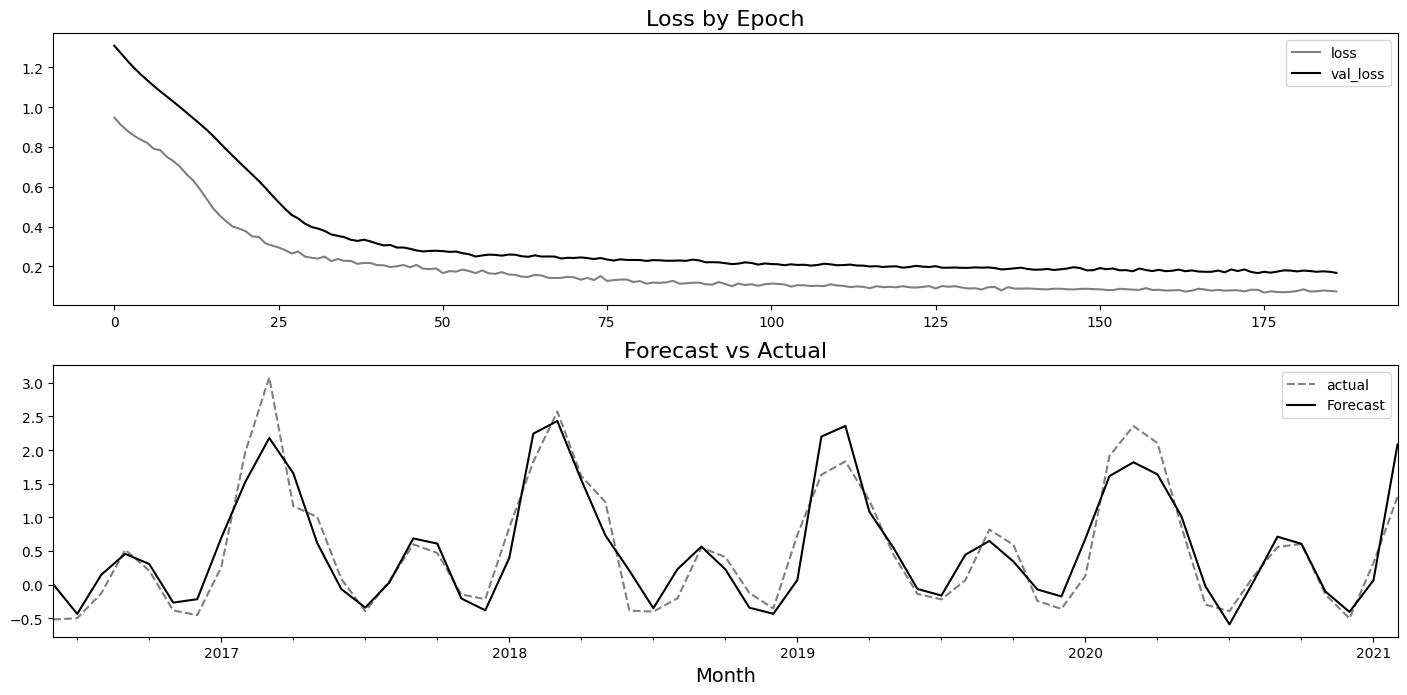

In [284]:
plot_forecast(model_en_lstm, x_test_en, y_test_en, test_en.index, history_en_lstm)

In [285]:
tf.keras.backend.clear_session()

In [286]:
model_a_m = create_model(train=x_train_air, units=32)
model_a_m.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 10, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 10, 32)         │         4,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 10, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 32)             │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,705 (49.63 KB)

 Trainable params: 12,705 (49.63 KB)

 Non-trainable params: 0 (0.00 B)

### Air Passenger

In [288]:
history_a_m = train_model_ts(model_a_m, x_train_air, y_train_air, x_val_air, y_val_air)

Epoch 1/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - loss: 0.8595 - mean_absolute_error: 0.7952 - root_mean_squared_error: 0.9231 - val_loss: 2.7546 - val_mean_absolute_error: 1.4665 - val_root_mean_squared_error: 1.6597
Epoch 2/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.6360 - mean_absolute_error: 0.6712 - root_mean_squared_error: 0.7948 - val_loss: 2.0601 - val_mean_absolute_error: 1.1986 - val_root_mean_squared_error: 1.4353
Epoch 3/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.4904 - mean_absolute_error: 0.5816 - root_mean_squared_error: 0.6985 - val_loss: 1.4789 - val_mean_absolute_error: 0.9156 - val_root_mean_squared_error: 1.2161
Epoch 4/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.3475 - mean_absolute_error: 0.4922 - root_mean_squared_error: 0.5881 - val_loss: 1.0389 - val_mean_absolute_error: 0.7551 - val_root_mean_squared_error: 1.0193
Epoch 5/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.2820 - mean_absolute_error: 0.4315 - root_mean_squared_error

In [293]:
model_a_m.evaluate(x=x_test_air, y=y_test_air)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 1.3138 - mean_absolute_error: 0.8395 - root_mean_squared_error: 1.1462


[1.3138225078582764, 1.1462209224700928, 0.8394703269004822]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step


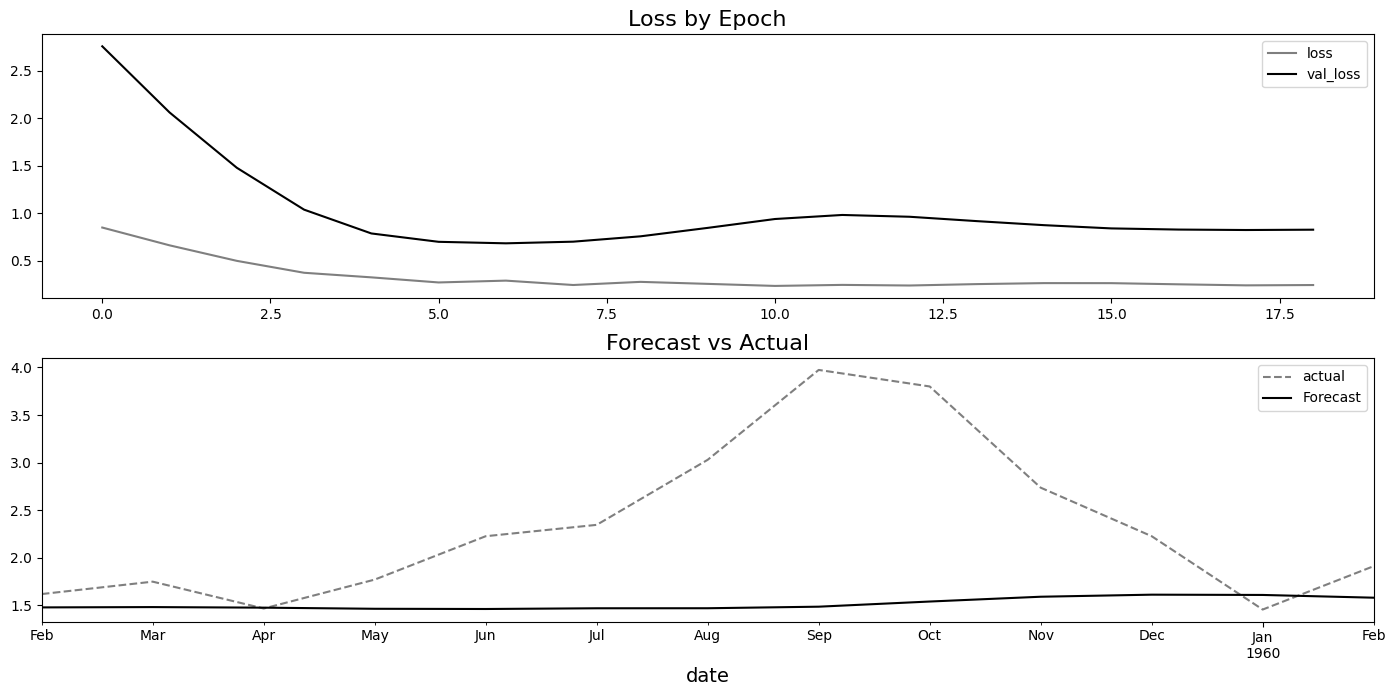

In [294]:
plot_forecast(model_a_m, x_test_air, y_test_air, test_air.index, history_a_m)